In [724]:
import pandas as pd
import numpy as np
import seaborn as sns 
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yfinance import download
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from fcmeans import FCM
from sklearn.datasets import make_blobs
from scipy.stats import shapiro, ttest_ind, skew, kurtosis
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif




In [726]:
#pip install pandas_datareader

In [728]:
#pip install pandas numpy matplotlib scikit-learn yfinance

In [730]:
import yfinance as yf

In [732]:
tesla = yf.download("TSLA")
df = yf.download(["TSLA"]), 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [734]:
df = yf.download("TSLA", start="2010-06-29", end="2025-04-15")

[*********************100%***********************]  1 of 1 completed


In [736]:
#data = yf.download("TSLA")
#start_date = "2010-06-29"
#end_date = "2025-04-15"

In [738]:
df.to_csv('TSLA_historical_data.csv')

In [740]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3722 entries, 2010-06-29 to 2025-04-14
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   3722 non-null   float64
 1   (High, TSLA)    3722 non-null   float64
 2   (Low, TSLA)     3722 non-null   float64
 3   (Open, TSLA)    3722 non-null   float64
 4   (Volume, TSLA)  3722 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 174.5 KB


In [742]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [744]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-04-08,221.860001,250.440002,217.800003,245.000000,171603500
2025-04-09,272.200012,274.690002,223.880005,224.690002,219433400
2025-04-10,252.399994,262.489990,239.330002,260.000000,181722600
2025-04-11,252.309998,257.739990,241.360001,251.839996,128948100
2025-04-14,252.350006,261.799988,245.929993,258.359985,100135200


In [746]:
df.shape

(3722, 5)

In [748]:
# To before modeling , I need to prepare the dataset for missing values, what is data types the Datasdet conducts, 
#and correct inconsistencies if there are ones.  
print(df.isnull().sum())

Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64


In [750]:
# Now I need to see what type of values the features are. 

print(df.dtypes)

Price   Ticker
Close   TSLA      float64
High    TSLA      float64
Low     TSLA      float64
Open    TSLA      float64
Volume  TSLA        int64
dtype: object


In [752]:
#For easier modeilng is better to modify dataset i which there won't be Tickers or missing values if could be still, 
#renaming Price in Date and checking if "Date" is the index. 

df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
print(df.columns)

Index(['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA'], dtype='object')


In [754]:
df.columns = df.columns.str.replace('_TSLA', '')

In [756]:
df.head()

# As a reslut we can see now Date has become Index and other features are columns. 

,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [758]:
# Now let's see what dataset is consistent 

df.describe()

,Close,High,Low,Open,Volume
count,3722.000000,3722.000000,3722.000000,3722.000000,3.722000e+03
mean,86.046623,88.004574,84.011386,86.082028,9.686498e+07
std,111.877430,114.538293,109.161892,111.990500,7.721903e+07
min,1.053333,1.108667,0.998667,1.076000,1.777500e+06
25%,12.333667,12.587500,12.095000,12.305667,4.966072e+07
50%,18.540667,18.799999,18.266666,18.526666,8.256975e+07
75%,185.867496,189.287506,182.000000,185.434998,1.224991e+08
max,479.859985,488.540009,457.510010,475.899994,9.140820e+08


In [760]:
#The dataset contains 3722 daily records — this aligns well with the period from Tesla IPO (June 2010) to April 2025.

#Closing Price (Clos)##:
#Mean: $86, #05
#Median (50%): $1, #.54
#Max: $4, #9.86
#Min: ##$1.05
#Standard deviation: $11#1.88 — very high, which indicates significatnliolai##-- ty.

#Volume:
#Mean dail volume: ~96,#, 9 mil1n
#Min: ~ 1#,, 78 mion
#Max: ~, #-#914 million
#Standard deviation very high (~77##.2 mllion)

#It is  that:
#Tesla trading volume varies wildly, which periods of intense mit could be happening
#market interest, like after some #news or product releases, or probably Elon Musk tweets.

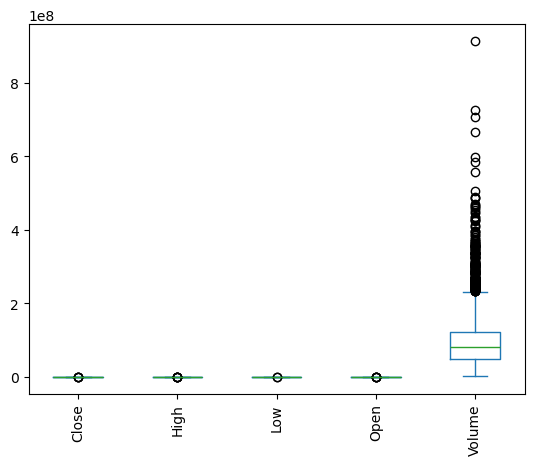

In [762]:
df.plot(kind='box', rot=90);

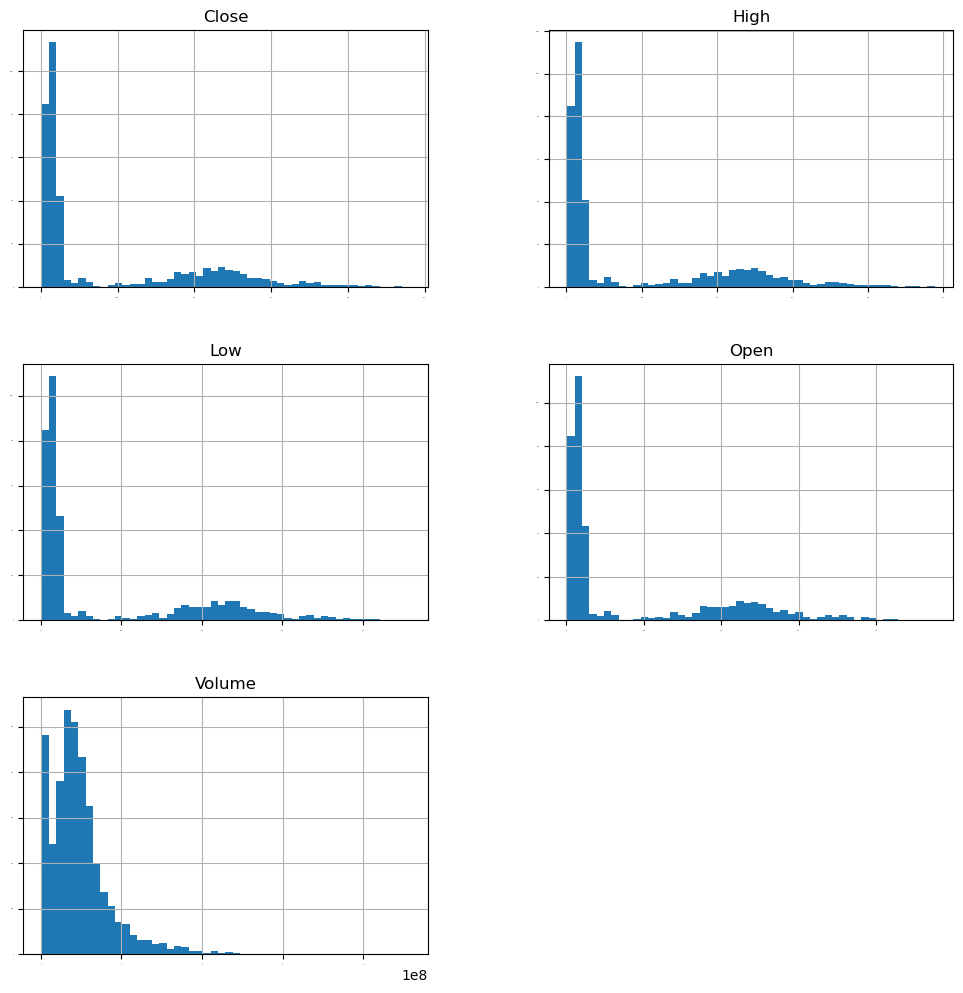

In [764]:
import matplotlib.pyplot as plt

df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

In [766]:
#"Don’t worry too much about normality when using ARIMA models. They are designed to model patterns in the data, not their distribution."
# Robert Nau (Duke University). 
#Time series models (ARIMA, HWES, SARIMAX) do not work 
#with the form of the distribution but rather with the dependency between observations over time (autocorrelation, seasonality, trend).

In [768]:
correlation_matrix=df.corr()
print(correlation_matrix)

           Close      High       Low      Open    Volume
Close   1.000000  0.999626  0.999658  0.999159  0.090471
High    0.999626  1.000000  0.999594  0.999684  0.093193
Low     0.999658  0.999594  1.000000  0.999604  0.086111
Open    0.999159  0.999684  0.999604  1.000000  0.089321
Volume  0.090471  0.093193  0.086111  0.089321  1.000000


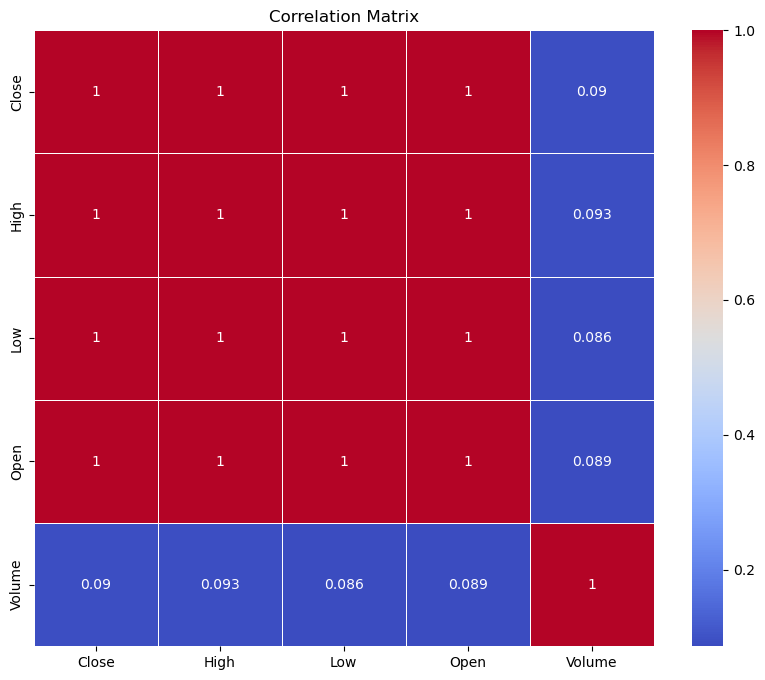

In [770]:
correlation_matrix = df.corr()  # Compute the correlation matrix

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

The lowest level of correlation are:
Volume vs Close: 0.09
Volume vs High: 0.093
Volume vs Low: 0.086
Volume vs Open: 0.089

This means:

Trading volume (Volume) is almost not linearly correlated with price.
That is, price does not depend directly on volume - at least not in a linear form.
This explains why Volume does not work as a strong predictor in simple models like Linear Regression) that again could be a booster for confiramtion 
of the following choice of Time Series as a forecasting analysis for this work

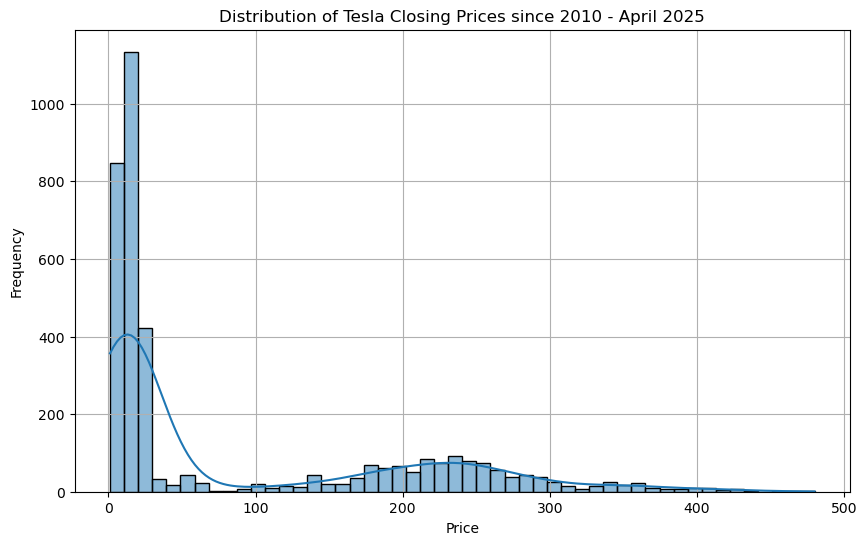

In [773]:

# Distribution of price since 2010 - April 2025
plt.figure(figsize=(10,6))
sns.histplot(df['Close'], kde=True, bins=50)
plt.title('Distribution of Tesla Closing Prices since 2010 - April 2025')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

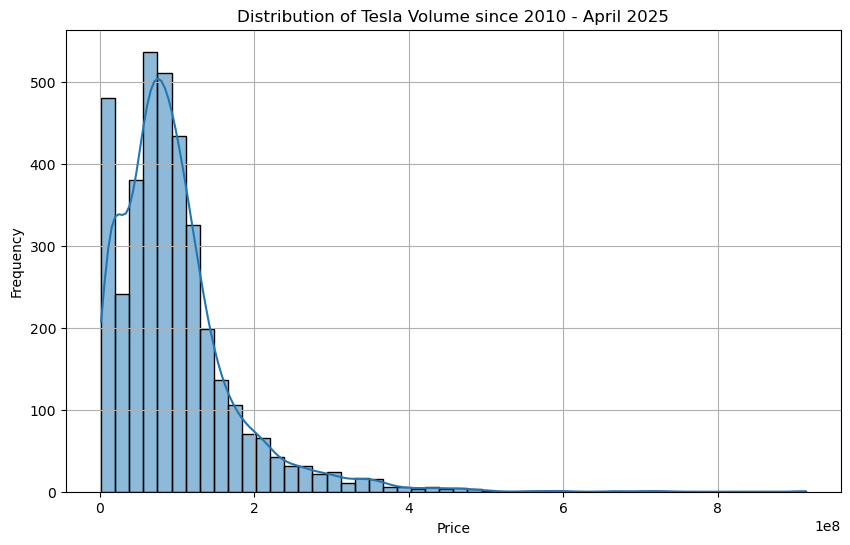

In [775]:
# Distribution of price since 2010 - April 2025
plt.figure(figsize=(10,6))
sns.histplot(df['Volume'], kde=True, bins=50)
plt.title('Distribution of Tesla Volume since 2010 - April 2025')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [777]:
#My decision is to observe the full evolution of the company, where we can see the early stages, periods of growth, 
#market cycles, and crises.
#The period from the beginning of IPO Co gives to see the whole the model from real-world scenarios of growth, decline, and recovery.
#More data - it can give better detection of long-term trends and the structure of seasonality.

In [779]:
#At the beginning let's make a plot of Close (Price) stock from the first day of IPO untill 15th April 2025

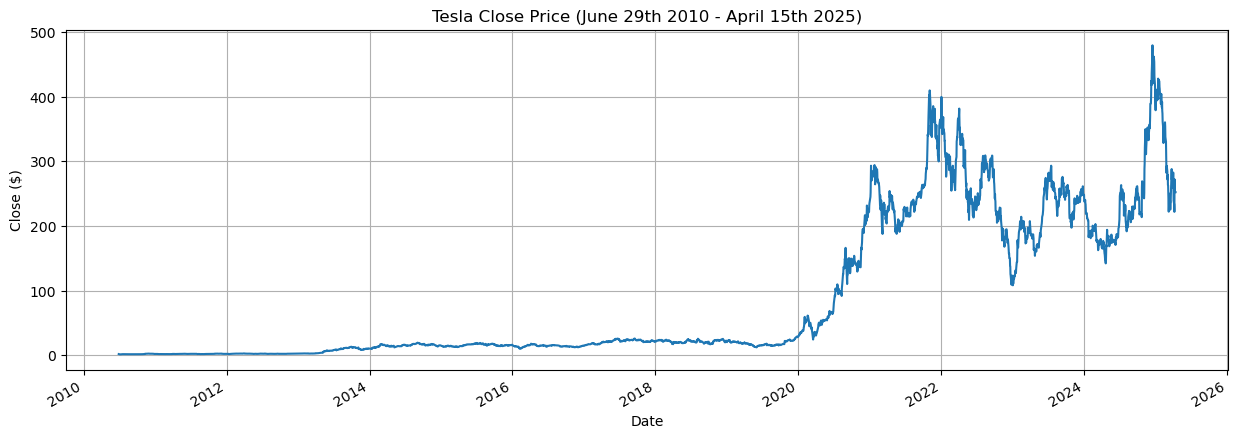

In [781]:
df['Close'].plot(figsize=(15,5), title='Tesla Close Price (June 29th 2010 - April 15th 2025)')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.grid()
plt.show()

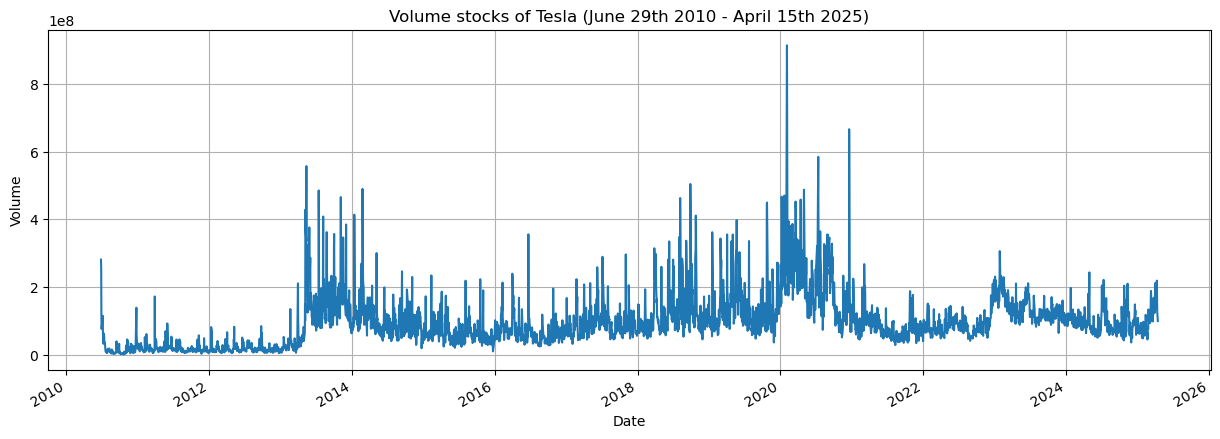

In [783]:


# Check and visualise a Volume trend 


df['Volume'].plot(figsize=(15,5), title='Volume stocks of Tesla (June 29th 2010 - April 15th 2025)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid()
plt.show()

In [785]:
# As one of the essential tasks is to predict a price (Close) for Tesla for next April 2026, let's model at the beginning the Close. 

#Being able to analyse a Tesla stock and how it performs via ARIMA or ARMA, SARIMA models and 
#finally predict the price for next 2026 we need to learn the followng factors:

#Trend,
#Seasonality,
#Ciclicity,
#Resudials 
#And finally, based on all of that to make a determination of a Series Time.



In [787]:
#it is crucial to carefully analyze the key time series components:

#Trend:
#Detecting the long-term movement of Tesla’s stock price over the years, such as periods of steady growth, corrections, or plateau phases.
#Tesla has a strong upward and curently  downward trends. 
# Upward trend we saw after a major event like product launching EV truck. 
#Downward trend we can observe in current days when E.Mask is heading DOGE and EV cars are boycotted do not buy in entrire world. 

#Focus on 'Close' price
df = df[['Close']]




In [789]:
df.head()

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [791]:
df.tail()

,Close
Date,
2025-04-08,221.860001
2025-04-09,272.200012
2025-04-10,252.399994
2025-04-11,252.309998
2025-04-14,252.350006


<Axes: xlabel='Date'>

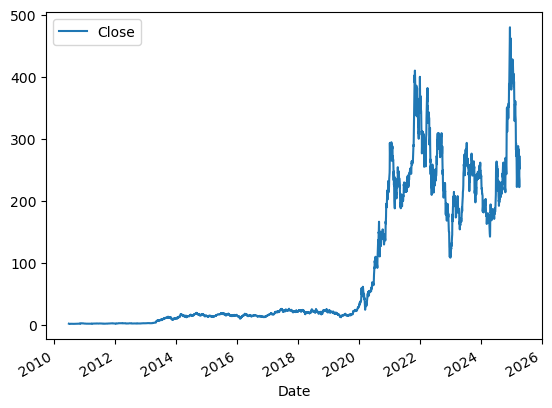

In [793]:
#Just for keeping in observation
df.plot()

In [795]:
#Seasonality:
# It helps to identify repeating patterns that occur at regular intervals, such as quarterly financial reoprting effects, 
#earnings season impacts, or even market rallies, particularly at the end of year.

# Cyclicality:
# helps us to understand longer-term cycles that influence in cause of diverce economic factors like market booms or recessions.
# In our case with Tesla it may reflect broader technology sector that we will observe later in this Juoyter Note in 
# a sector of Clustering with S&P 500.  

#Residuals:
#Or in Traiding world it calls Noises. After removing trend and seasonality we can still observe the irregular fluctuations 
#that to must be checked and considered for precisional modelling.

In [797]:
print(df.index)
print(df.index.freq) 

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
               '2010-07-12', '2010-07-13',
               ...
               '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-04',
               '2025-04-07', '2025-04-08', '2025-04-09', '2025-04-10',
               '2025-04-11', '2025-04-14'],
              dtype='datetime64[ns]', name='Date', length=3722, freq=None)
None


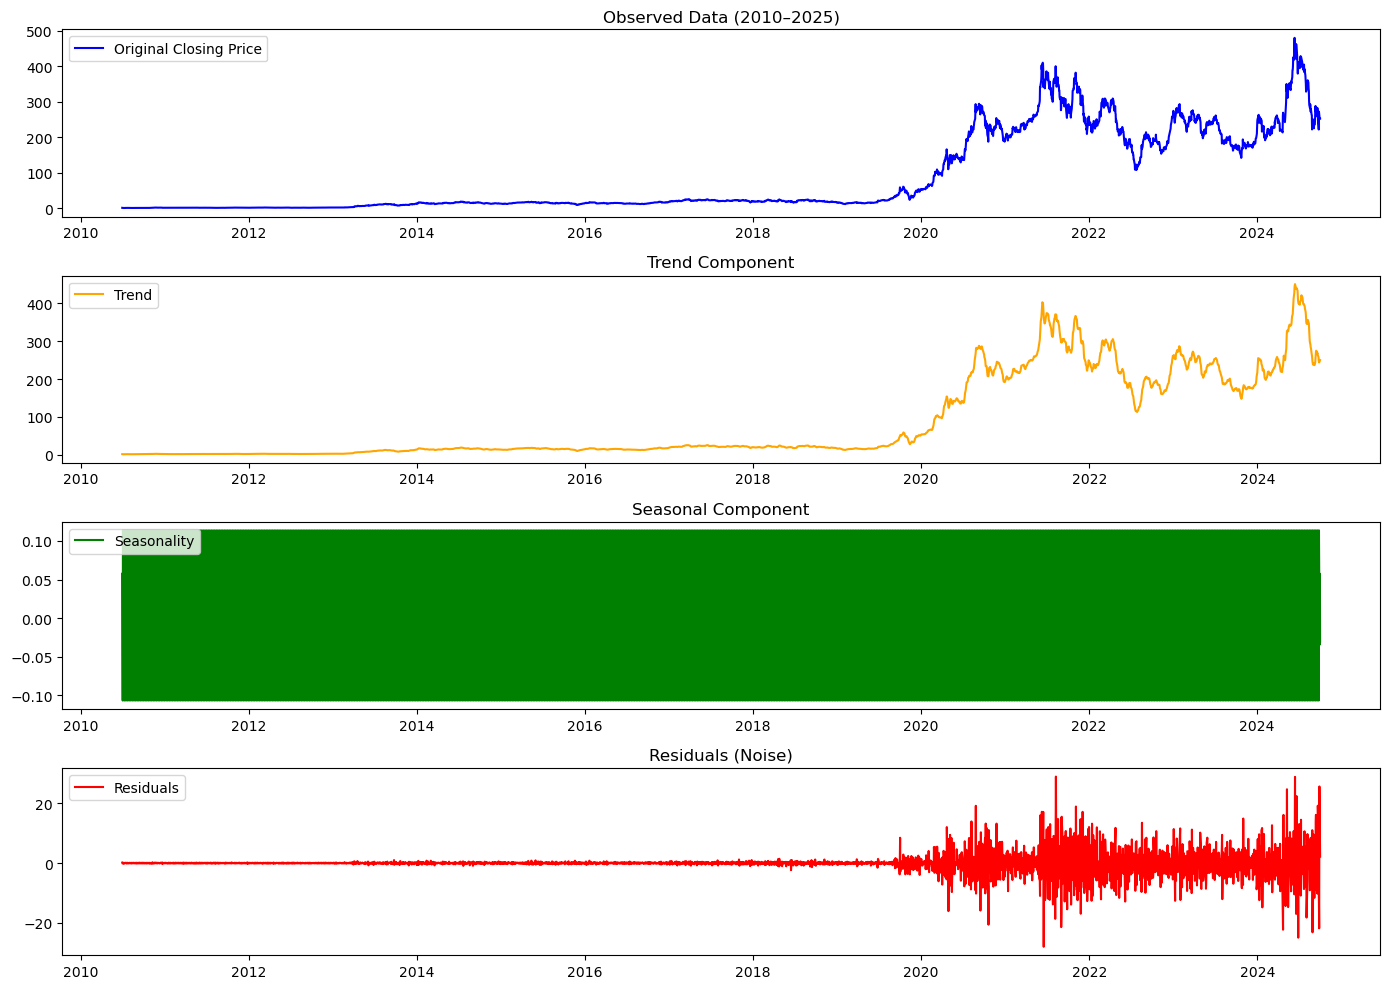

In [799]:
# Yearly period from 2010 - April 2025 - Decomposition 

df.index = pd.date_range(start='2010-06-29', periods=len(df), freq='B', ) # B - Business days 

decomposition = seasonal_decompose(df['Close'])
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Original Closing Price', color='blue')
plt.title('Observed Data (2010–2025)')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals (Noise)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [801]:
# Based on the decomposition above, there is no strong or stable seasonality in the Tesla closing prices with years period.
#The seasonal component appears weak and erratic, suggesting that trend and noise dominate the time series behavior.
#The seasonal component appears weak and erratic, suggesting that trend and noise dominate the time series behavior.


# Period/Decompositon 1 = 21 Traiding days  → First Decomposition
#Trend is okay, but Seasonality is completely flat and noisy, almost meaningless.
#Residuals are much larger and chaotic.


#Period/Decompostion 2  = 252 (Trading Days ~1 Year) → Second Decomposition
#Trend looks smooth and meaningful: captures Tesla’s major growth (2019–2021) and later flattening.
#Seasonality shows clear, strong repeating patterns — yearly cycles.
#Residuals are relatively small and random after 2019 (good for modeling).
#This decomposition looks very clean.
#Strong annual seasonality captured.


#This guides us that:
#21 Traiding Days Decompostion1 makes sense for Time series (resampled data), not for monthly data.


#Conclusion: What to take for further modeling?

# In my opinion is better to use period = 21 trading days:

# 21 trading days ≈ 1 month of market activity
#Monthly cycles are often observed in investor behavior (e.g., earnings cycles, portfolio adjustments, salary-based investments)
#It's short enough to capture patterns and regularities that 252-day or even 90-day seasonality might miss

#Seasonal SARIMA - repeating yearly patterns in trading days, and will take seasonal period = 21 days 
#Holt-Winters - seasonal period = 21 days


In [803]:
# Resample to monthly average to better see patterns
#df_monthly = df['Close'].resample('M').mean() # that minds Month or Monthly trend. 


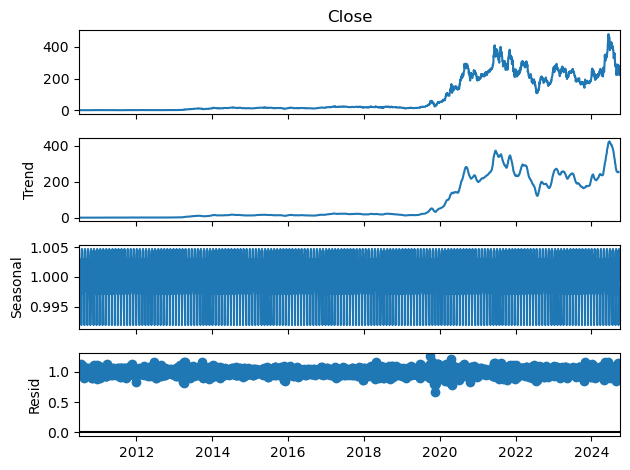

In [805]:
# From decomposition I tried to deetermime what is a period it would be better to consider for further modelling. 

#Decomposition 1 - is a 21 days period. 

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition1 = seasonal_decompose(df['Close'], model='multiplicative', period=21)  # 21 days of trades.
decomposition1.plot()
plt.show()

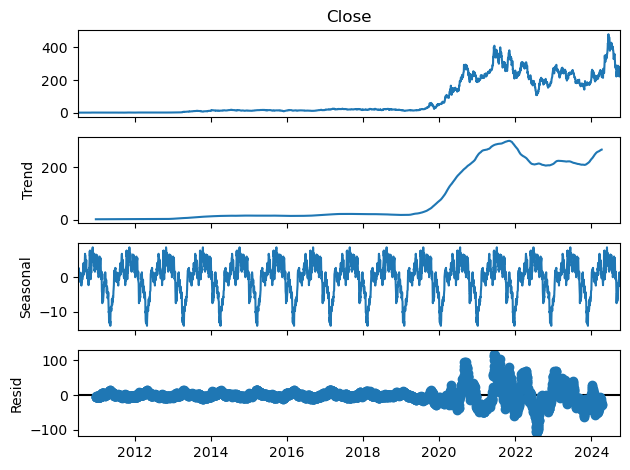

In [809]:
#Decomposition 2 - is 252 dayly average traiding period that considers 252 traiding days per year. 

decomposition2 = seasonal_decompose(df['Close'], model='additive', period=252)  # 252 — is avarge trading days per year 
decomposition2.plot()
plt.show()

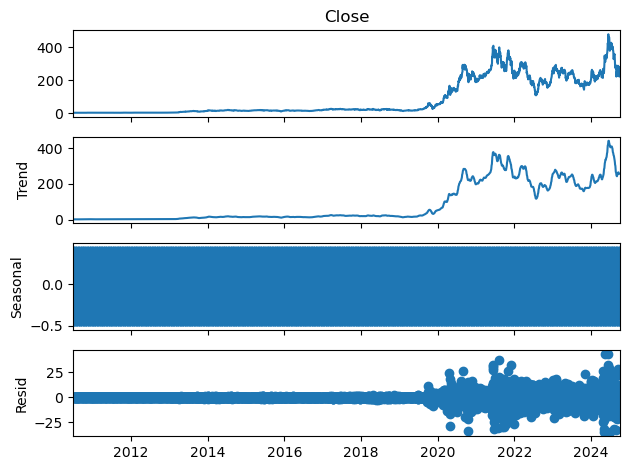

In [811]:
decomposition3 = seasonal_decompose(df['Close'], model='additive', period=12)  # 12 — is monthly  
decomposition3.plot()
plt.show()

In [813]:
#pip install numpy==1.26.4

Series Time/ Hypothesis Stationary 

In [816]:
 #Stationarity

from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test (ADF Test)
ad_fuller_result = adfuller(df['Close'])

# Display the outcome of Augmented Dicky-Fuller Test
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.4121076394379053
p-value: 0.5764579968696936


<Axes: >

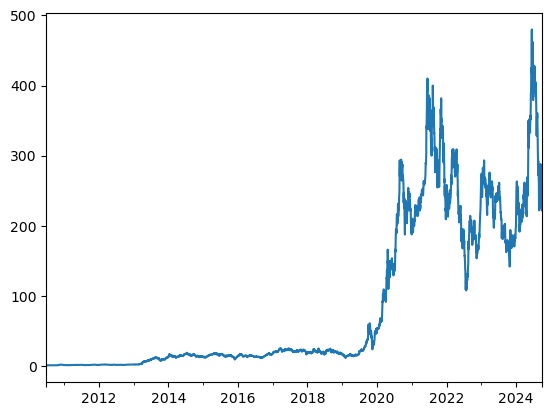

In [818]:
df['Close'].plot()

In [820]:
# The resulting p-value of 0.576 indicates that Tesla closing price series is non-stationary, 
#and differencing is required before applying time series models like ARIMA or SARIMA.
 

In [822]:
df['Close Difference'] = df['Close'] - df['Close'].shift(21)
# Shift index by desired number of periods with an optional time ⁠ freq ⁠.

# Show first five records
df.head(50)

# 21 days is Nan that we can apply function drop for them


,Close,Close Difference
2010-06-29,1.592667,NaN
2010-06-30,1.588667,NaN
2010-07-01,1.464000,NaN
2010-07-02,1.280000,NaN
2010-07-05,1.074000,NaN
2010-07-06,1.053333,NaN
2010-07-07,1.164000,NaN
2010-07-08,1.160000,NaN
2010-07-09,1.136667,NaN
2010-07-12,1.209333,NaN


In [824]:
df.tail()

,Close,Close Difference
2024-09-26,221.860001,-0.289993
2024-09-27,272.200012,41.620010
2024-09-30,252.399994,4.309998
2024-10-01,252.309998,11.630005
2024-10-02,252.350006,2.370010


In [826]:
# Drop NAn values
df.dropna(subset = ["Close Difference"], inplace = True)

In [828]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Close):
    result=adfuller(Close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [830]:
## Again test dickey fuller test
adfuller_test(df['Close Difference'])

ADF Test Statistic : -9.87441705365326
p-value : 3.9168885710856707e-17
#Lags Used : 30
Number of Observations Used : 3670
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [832]:
# With applying a difernce, we received 
#p-value: 3.9168885710856707e-17 (which is essentially 0), that confirming that the differenced series is now stationary.

#Therefore, the data is suitable for ARIMA and SARIMA modeling with a differencing order of d = 1.


<Axes: >

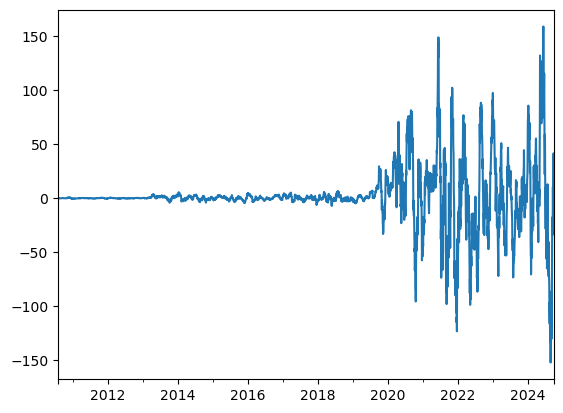

In [834]:
df['Close Difference'].plot()

In [836]:
# Based on the ADF Test Statisitic we can see that Time Series is non-stationary, as p-value >= 0.05. 
# We need to find Deference in order to receive Stationarity and able to apply ARIMA,SARIMA modeling for further forecasting 

linkcode
ADF Test for Stationarity

ADF test is a common statistical test used to test whether a given Time Series is Stationary or not. It is one of most commonly used statistical test when it comes to analyzing the stationarity of a series.

Null Hypothesis :- The Time Series is not stationary.

Alternate Hypothesis :- The Time series is stationary.

p-value > 0.05 :- Fails to reject null hypothesis, the data has a unit root and not stationary.

p-value < 0.05 :- Reject null hypothesis, the ata does not have a unit root and is stationary

ACF and PACF Plots

We can use the statsmodels library to build auto-correlation (ACF) and partial auto-correlation plots from the differenced series. ACF describes how well the present value of the series is related with its past values while PACF finds correlation of the residuals with the next lag value.

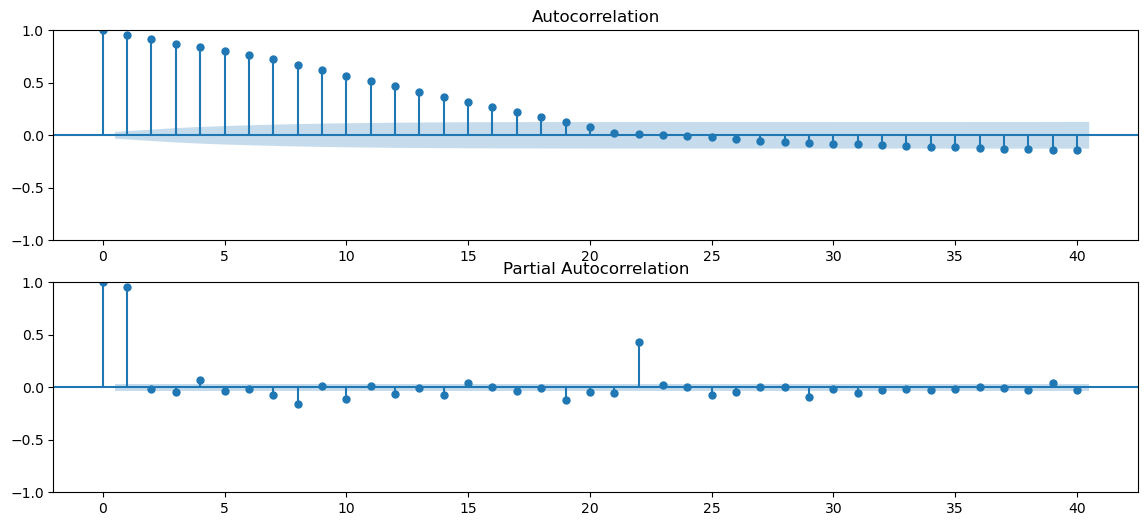

In [840]:
import statsmodels.api as sm
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Close Difference'].dropna(),lags = 40,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Close Difference'].dropna(),lags = 40,ax = ax2)
plt.show()

In [842]:
#Based on the ACF and PACF plots:
#The time series is non-stationary, so d=1 was chosen after differencing.
#The PACF shows significant spikes at lags 1 and 2, probably I take p=2.
#The ACF shows a slower decay, indicating q=1 or q=2.
#Therefore, the ARIMA(2,1,1) model could be selected as a starting point, but we will see that bellow. 



SARIMA 

In [845]:
import warnings
warnings.filterwarnings('ignore') 

# A nested loop is written to calculate the AIC values
from statsmodels.tsa.arima.model import ARIMA


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
# A nested loop is written to calculate the AIC values
aicVal=[]
for d in range(1,3): # Difference that we determine 1 
    for ari in range(0, 3):  # p = 0, 1, 2 (AR) Autoregression
        for maj in range(0,3):  # q = 0, 1, 2 (MA)
            try:
                arima_obj = ARIMA(df['Close'], order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)




[[0, 1, 0, 23217.947809086727], [0, 1, 1, 23218.514616482124], [0, 1, 2, 23220.035035206063], [1, 1, 0, 23218.481398667216], [1, 1, 1, 23219.396169082276], [1, 1, 2, 23221.25100736291], [2, 1, 0, 23219.978764828713], [2, 1, 1, 23221.258449764155], [2, 1, 2, 23223.34615313633], [0, 2, 0, 25849.543357950974], [0, 2, 1, 23222.821421118064], [0, 2, 2, 23222.931601819044], [1, 2, 0, 24708.390040872502], [1, 2, 1, 23222.893997830037], [1, 2, 2, 23224.42856052483], [2, 2, 0, 24300.48325512717], [2, 2, 1, 23224.380391099847], [2, 2, 2, 23224.233985026003]]


In [846]:
# [0, 1, 0, 23107.12058873855] - this is the best composition. 
#Stationarity Check: Ensures the time series is stable (no changing mean/variance).
#SARIMA Parameters:
#(p, d, q): Non-seasonal AR, differencing, and MA terms.
#(P, D, Q)[21]: Seasonal equivalents (here, 21-days season).
#AIC Metric: Lower = Better model fit.


In [849]:
# order = (0, 1, 0) means 
# First 0 for auto regressive model, 1 for difference, and second 0 for moving average
# seasonal_order = (0, 1, 0, 21) means
# 21 additional parameter means number of observations per year or the period
best_model = SARIMAX(df['Close'], order = (0, 1, 0), seasonal_order = (0, 1, 0, 21)).fit(dis = -1) # for find the best value 

# Display the summary of the model
print(best_model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44867D+00    |proj g|=  7.67111D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.487D-07   3.449D+00
  F =   3.4486582494489908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 3701
Model:      

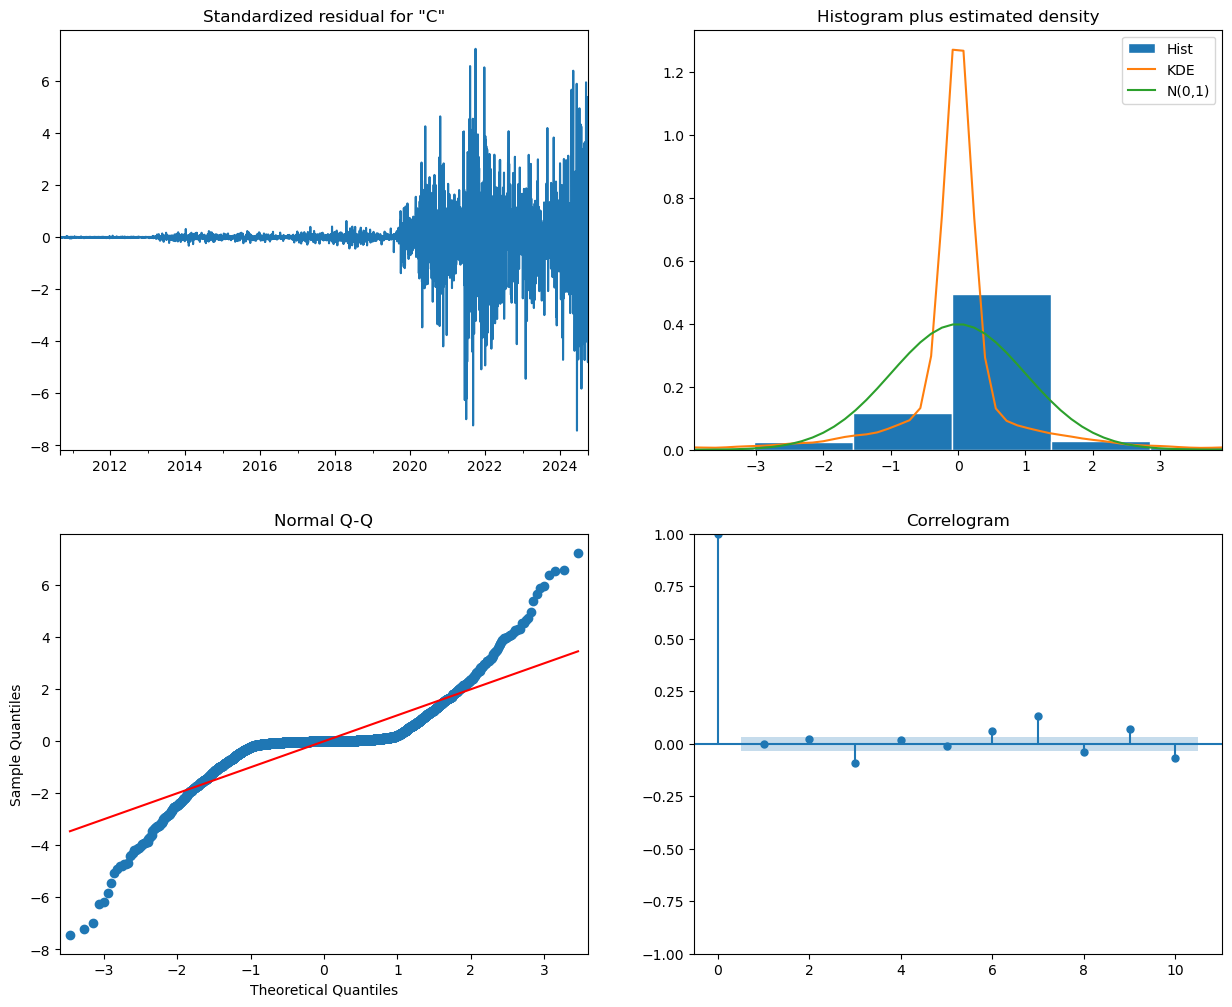

In [851]:
# Diagnosing the model residuals
best_model.plot_diagnostics(figsize = (15, 12))
plt.show()

In [853]:
#Top-left plot (residuals over time):
#The residuals do not appear to be pure white noise—especially toward the end, where volatility increases significantly.
#This may indicate heteroskedasticity (changing variance), which ARIMA did not fully account for.
#Top-right plot (Histogram and KDE):
#The residuals are clearly not normally distributed: the shape is sharp, narrow, and deviates significantly from the normal distribution (green curve).
#This may reduce the reliability of forecast interpretation.
#Q-Q Plot (bottom-left):
#The points do not follow the red line, indicating that the residuals are not normal.
#There are strong deviations at both ends—suggesting the presence of fat tails.
##There are some autocorrelations above the confidence interval.
#This suggests that the model did not capture all underlying dependencies, and additional AR or MA terms may be needed.


In [855]:
# According to R. Hyndman and G. Athanasopoulos  Hyndman & Athanasopoulos ("Forecasting: Principles and Practice", 2021):
#“Over-differencing (d > 1) can lead to overdamped models. Always check residuals before increasing d.” 

# In this case, let's try ARIMA(1,1,0) or ARIMA(0,1,1) — using one AR or one MA term can help us eliminate dependency in the residuals.

In [857]:
#[1, 1, 0, 23107.662497347683] 

In [859]:
best1_model = SARIMAX(df['Close'], order = (1, 1, 0), seasonal_order = (1, 1, 0, 21)).fit(dis = -1) # for find the best value 

# Display the summary of the model
print(best1_model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32904D+00    |proj g|=  3.10317D-02

At iterate    5    f=  3.31151D+00    |proj g|=  5.79351D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   5.790D-06   3.312D+00
  F =   3.3115072011668003     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                           

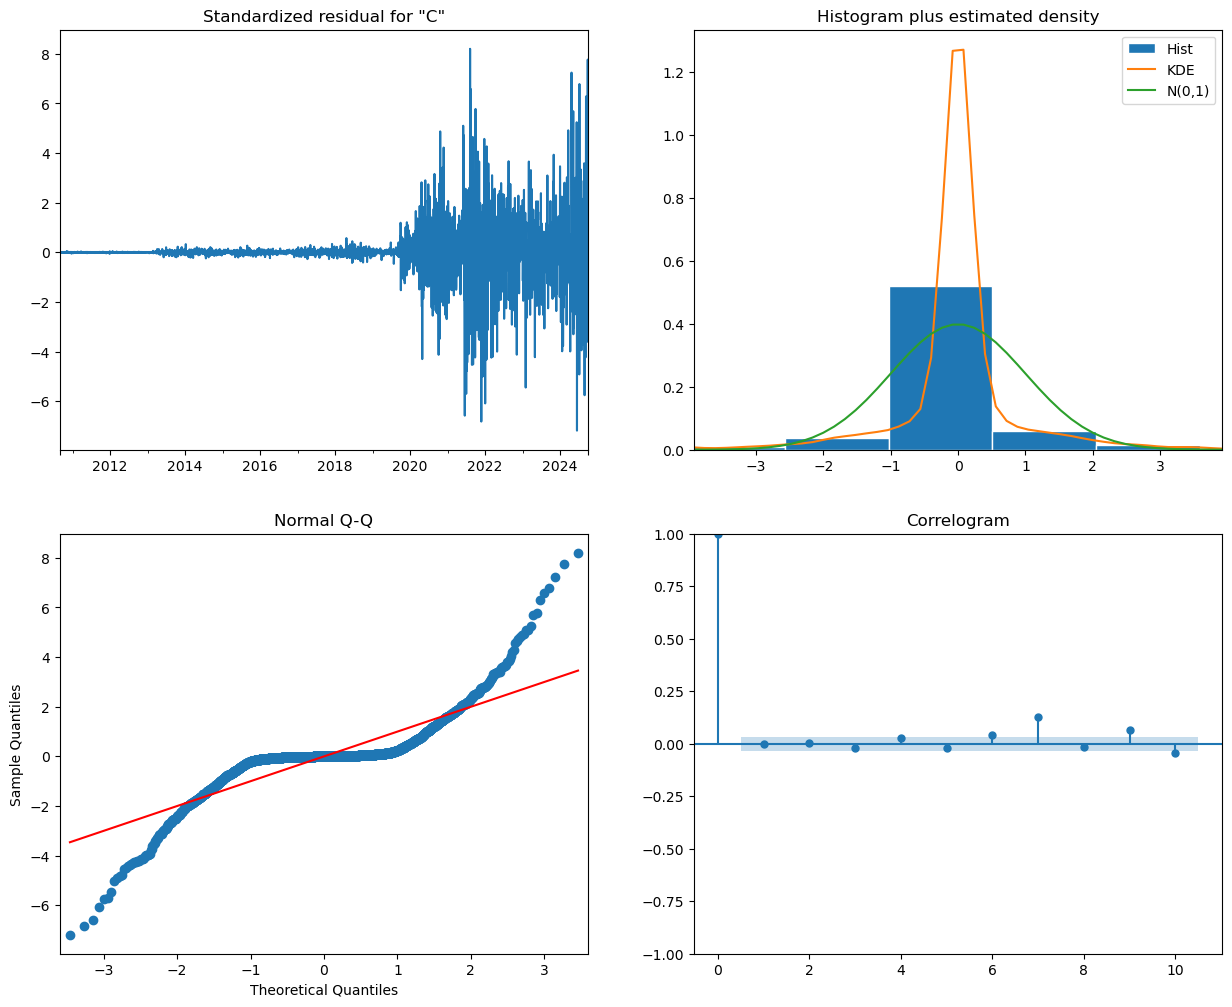

In [861]:
# Diagnosing the model residuals
best1_model.plot_diagnostics(figsize = (15, 12))
plt.show()

In [863]:
# As we can see still, it is not appropriate results. 

In [865]:
 # [0, 1, 1, 23107.695526925665]

In [867]:
import warnings
warnings.filterwarnings('ignore') 

In [869]:
best2_model = SARIMAX(df['Close'], order = (0, 1, 1), seasonal_order = (0, 1, 1, 21)).fit(dis = -1) # for find the best value 

# Display the summary of the model
print(best2_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23943D+00    |proj g|=  5.46161D-02


 This problem is unconstrained.



At iterate    5    f=  3.13569D+00    |proj g|=  5.44313D-03

At iterate   10    f=  3.13244D+00    |proj g|=  1.76868D-03

At iterate   15    f=  3.13210D+00    |proj g|=  9.60741D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   9.607D-05   3.132D+00
  F =   3.1320956589213265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 3701
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 21)   Log

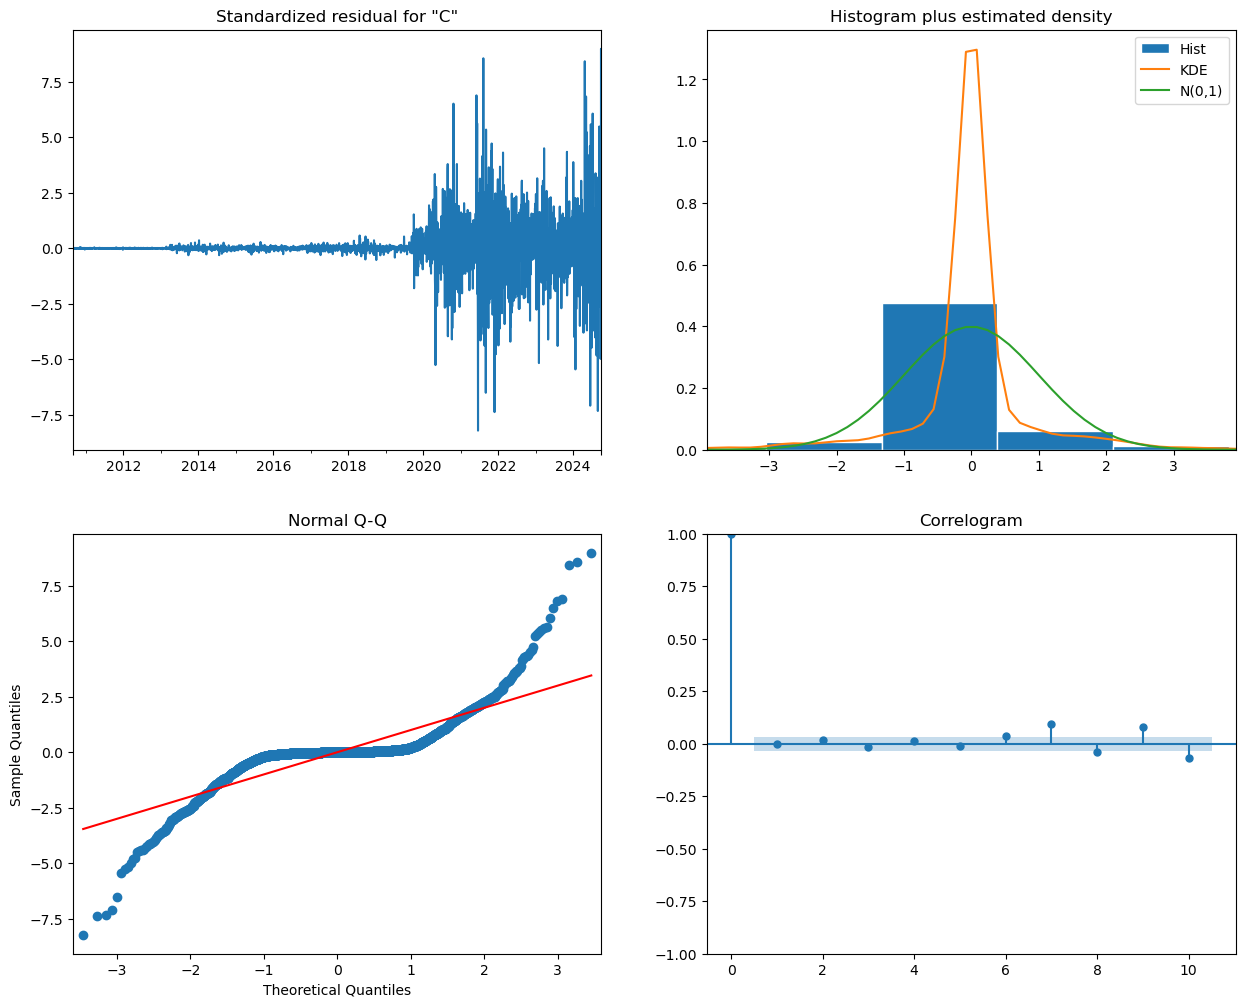

In [870]:
best2_model.plot_diagnostics(figsize = (15, 12))
plt.show()

In [873]:
#1, 1, 1, 23108.583426942452]

In [875]:

best_model3 = SARIMAX(df['Close'], order = (1, 1, 1), seasonal_order = (1, 1, 1, 12)).fit(dis = -1) # for find the best value 

# Display the summary of the model
print(best_model3.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25120D+00    |proj g|=  6.16369D-02

At iterate    5    f=  3.13741D+00    |proj g|=  1.28152D-02

At iterate   10    f=  3.13341D+00    |proj g|=  2.25453D-03

At iterate   15    f=  3.13275D+00    |proj g|=  1.70242D-03

At iterate   20    f=  3.13267D+00    |proj g|=  5.94094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   3.149D-05   3.133D+00
  F =   3.1326736209781321     

CONVERG

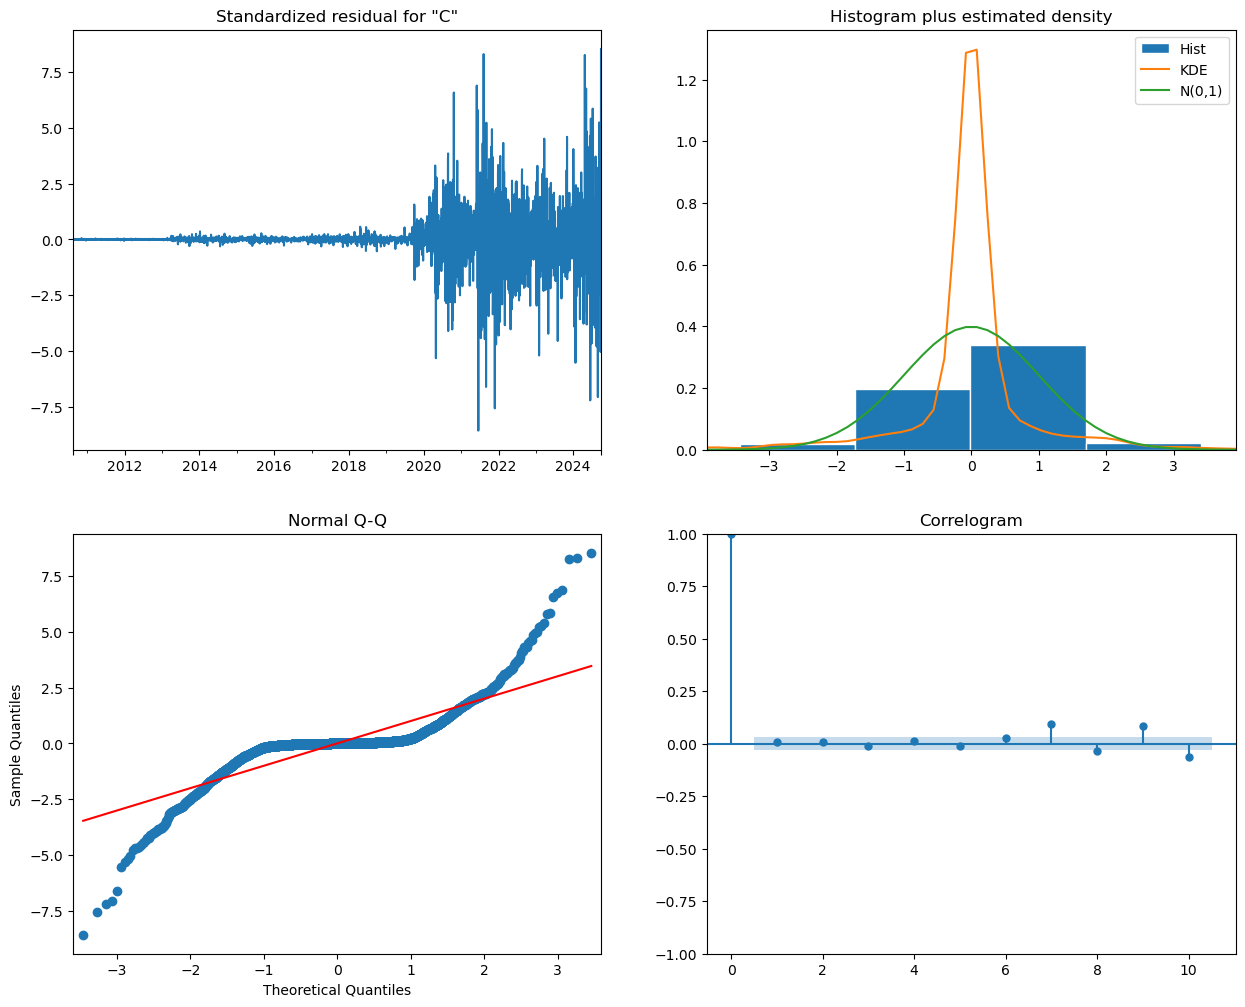

In [877]:
best_model3.plot_diagnostics(figsize = (15, 12))
plt.show()

In [879]:
#d=1 worked successfully:
#The first-order differencing (d=1) effectively removed the trend, making the series more stationary.
#Basic Autoregressive Structure (p=1, q=0):
# With position p=1 (AR term) and q=0 (no MA term) means the model is a simple autoregressive process (AR(1)).
#Residual has issues indicate underfitting:
#- non-normal residuals as Deviations from normality in Q-Q plots or skewness/kurtosis.
#Remaining autocorrelation - significant lags in the ACF/PACF of residuals.

# Conclusion: The model is underfitting—it fails to capture all patterns in the data.

In [881]:
#"If residuals show autocorrelation, the model is misspecified. Try adding AR or MA terms, or seasonal components."
#- Hyndman, R. J., & Athanasopoulos, G. (2021). Forecasting: Principles and Practice (3rd ed.). OTexts.

In [883]:
# In this case, I'm trying to add more AR/MA terms p=2, q=1.
# And check for Seasonality , adding seasonal terms daiy data. seasonal_order=(1,1,1,5) for monthly data

In [885]:
#Facebook Prophet uses :
#Combines SARIMA with nonlinear trends to handle residual autocorrelation.

#Kaggle gives examples:
#Winning solutions for time series  M5 Forecasting often use:
#Higher-order ARIMA (e.g., ARIMA(3,1,2)) when simpler models underfit.
# And seasonal terms ( S= 5 days for weekly data or 12 monthly.

5 days Seasonal period 

In [888]:
 #Генерация дат для примера (замените на ваши реальные данные)
date_rng = pd.date_range(start='2010-06-29', end='2025-04-15', freq='D')
df = pd.DataFrame(date_rng, columns=['Date'])
df['Close'] = np.random.randn(len(date_rng)).cumsum() + 100  # Имитация ценового ряда
df.set_index('Date', inplace=True)

In [890]:
# Подбор параметров SARIMA
import warnings
warnings.filterwarnings('ignore') 
aicVal = []
seasonal_period = 5  # 5-дневная сезонность


for d in range(1,3): # Difference that we determine 1 
    for ari in range(0, 3):  # p = 0, 1, 2 (AR) Autoregression
        for maj in range(0,3):  # q = 0, 1, 2 (MA)
            try:
                arima_obj = ARIMA(df['Close'], order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)


[[0, 1, 0, 15264.265623783653], [0, 1, 1, 15264.576499668103], [0, 1, 2, 15266.489878810082], [1, 1, 0, 15264.591682268609], [1, 1, 1, 15266.549743488227], [1, 1, 2, 15263.987250234788], [2, 1, 0, 15266.456725762797], [2, 1, 1, 15263.979421029431], [2, 1, 2, 15268.822144284597], [0, 2, 0, 18911.535926608343], [0, 2, 1, 15273.030708489045], [0, 2, 2, 15273.298859162427], [1, 2, 0, 17439.341592090736], [1, 2, 1, 15273.301652761676], [1, 2, 2, 15276.272578504357], [2, 2, 0, 16863.170962590862], [2, 2, 1, 15275.175684517102], [2, 2, 2, 15276.85657158138]]


In [892]:
best_model4 = SARIMAX(df['Close'], order = (1, 1, 0), seasonal_order = (1, 1, 0, 5)).fit(dis = -1) # for find the best value 

# Display the summary of the model
print(best_model4.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63510D+00    |proj g|=  1.74073D-01

At iterate    5    f=  1.61711D+00    |proj g|=  9.23701D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   9.237D-06   1.617D+00
  F =   1.6171094536913950     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                            

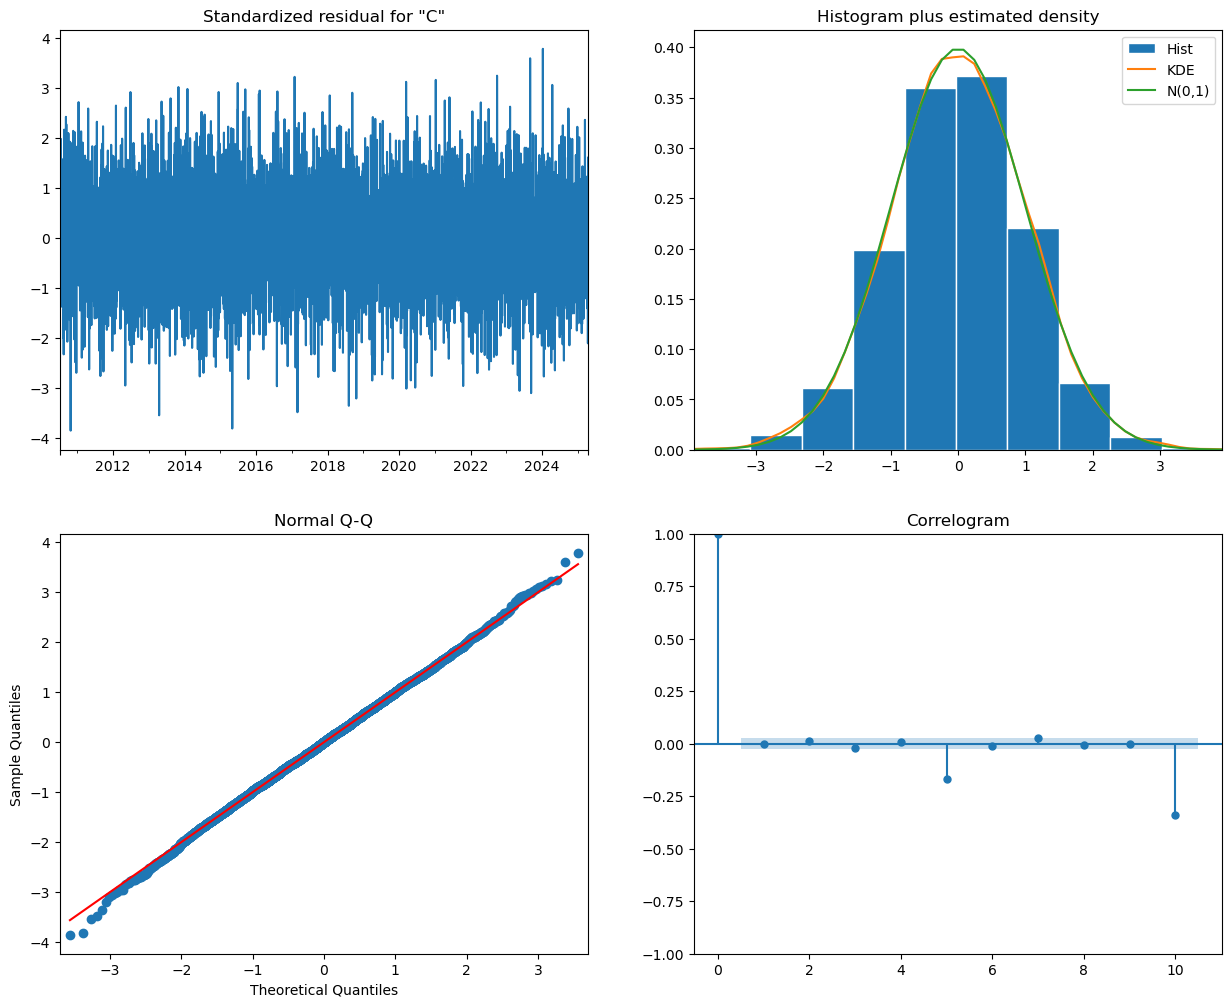

In [894]:
best_model4.plot_diagnostics(figsize = (15, 12))
plt.show()

In [896]:
#  Tesla’s stocks are extreme volatilitly.  
#SARIMA can still provide reasonable short-term forecasts if the residuals show clear in autocorrelation. 
#QQ-Plot may require non-normal models for accurate risk assessment
#Could indicate momentum effects or speculative trading patterns, that may guide us to 
#add external variables like NASDAQ index in order to get more precise forecast. 

ARIMA

In [899]:
#As we had for SARIMA model at the beggining 21 monthly periods, we can tried to modeilg with the same seasonal period. 

In [901]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA

# Call ARIMA function to train the model on the 'Close' price
model = ARIMA(df['Close'], order = (0,0,0)) #(1, 1, 0)) # 1- AR, 1 - Diffecrece -, 0 - MA we not taking here . Later Mo explain 

# Train ARIMA Model on the 'Close' price dataset
results_AR = model.fit()

In [903]:
# Store one difference value of the 'Close' column
first_order_diff = df['Close'].diff(1)

# Display the first five records
first_order_diff.head(21)


Date
2010-06-29         NaN
2010-06-30   -0.118199
2010-07-01   -0.275916
2010-07-02   -0.509157
2010-07-03   -0.299369
2010-07-04   -0.344417
2010-07-05    0.021462
2010-07-06   -0.487564
2010-07-07    0.211309
2010-07-08    0.063877
2010-07-09    0.972197
2010-07-10   -0.136467
2010-07-11   -1.805385
2010-07-12    0.826975
2010-07-13   -1.226763
2010-07-14    2.573355
2010-07-15   -0.912087
2010-07-16    1.252444
2010-07-17    0.455830
2010-07-18   -1.368064
2010-07-19    0.607690
Name: Close, dtype: float64

In [905]:
# Drop the first row of 'Close' column because It has 'NaN' value
first_order_diff = df['Close'].diff(1).dropna()

# Display the first five records
first_order_diff.head()

Date
2010-06-30   -0.118199
2010-07-01   -0.275916
2010-07-02   -0.509157
2010-07-03   -0.299369
2010-07-04   -0.344417
Name: Close, dtype: float64

Text(0.5, 1.0, 'First-order differences of Tesla 2010-June 2025-April')

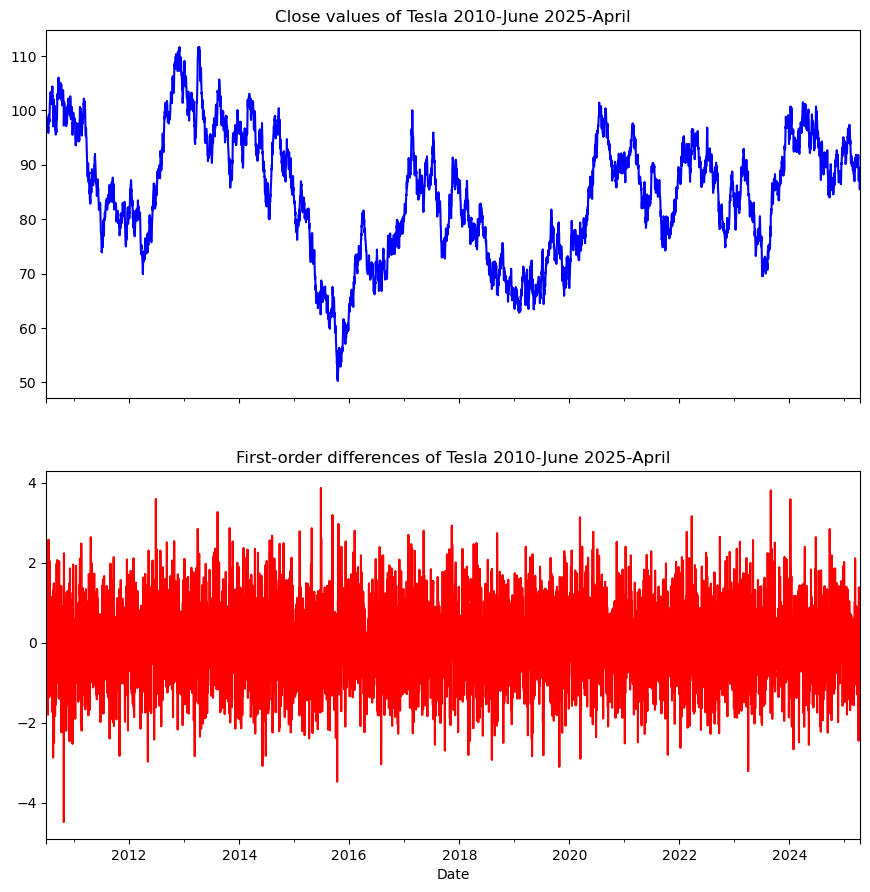

In [907]:
# Declare the fig abd ax as two arguments 
fig, ax = plt.subplots(2, sharex = True)
fig.set_size_inches(10.5, 10.5)
df['Close'].plot(ax = ax[0], color = 'b')
ax[0].set_title('Close values of Tesla 2010-June 2025-April')
first_order_diff.plot(ax = ax[1], color = 'r')
ax[1].set_title('First-order differences of Tesla 2010-June 2025-April')

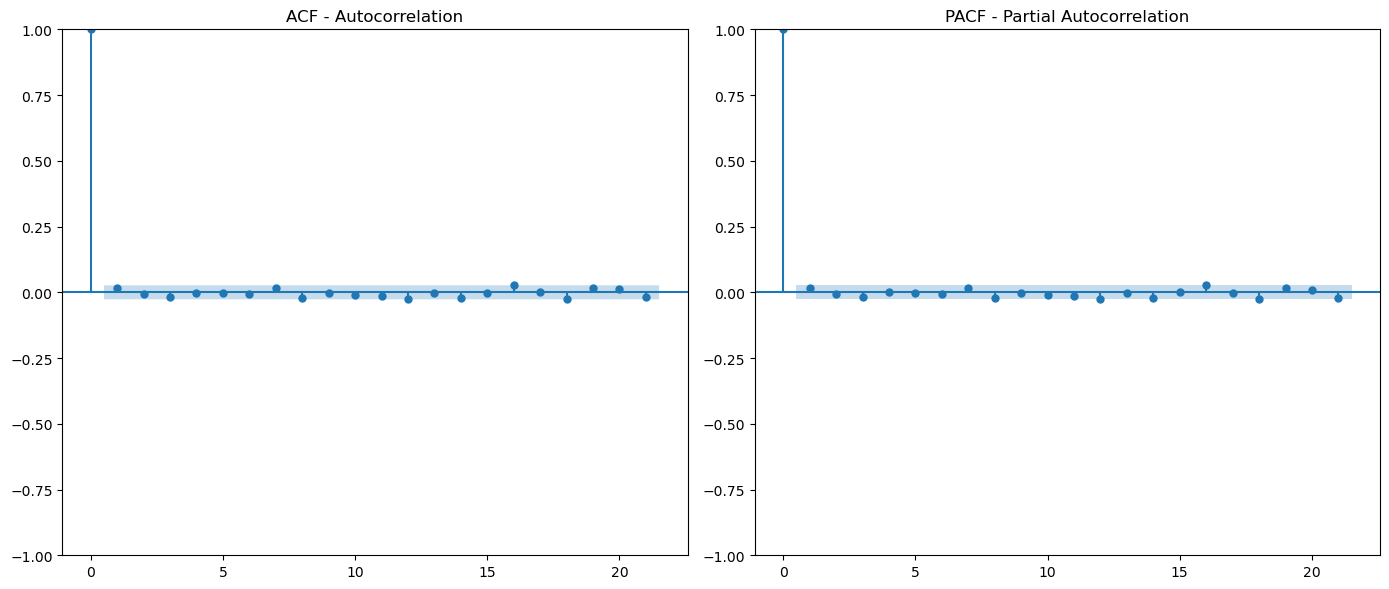

In [909]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF and PACF plots with 21 lags
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(first_order_diff, lags=21, ax=plt.gca()) # 21 traiding days
plt.title('ACF - Autocorrelation')

plt.subplot(1, 2, 2)
plot_pacf(first_order_diff, lags=21, ax=plt.gca())
plt.title('PACF - Partial Autocorrelation')

plt.tight_layout()
plt.show()

In [911]:
# A nested loop is written to calculate the AIC values
aicVal=[]# Acai value 
for d in range(1,4):
    for ari in range(0, 4):
        for maj in range(0,4):
            try:
                arima_obj = ARIMA(df['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

[[0, 1, 0, 15264.265623783653], [0, 1, 1, 15264.576499668103], [0, 1, 2, 15266.489878810082], [0, 1, 3, 15266.395123467451], [1, 1, 0, 15264.591682268609], [1, 1, 1, 15266.549743488227], [1, 1, 2, 15263.987250234788], [1, 1, 3, 15268.393378718087], [2, 1, 0, 15266.456725762797], [2, 1, 1, 15263.979421029431], [2, 1, 2, 15268.822144284597], [2, 1, 3, 15264.449871729987], [3, 1, 0, 15266.420325924842], [3, 1, 1, 15268.421738354396], [3, 1, 2, 15270.425410893378], [3, 1, 3, 15273.037780325014], [0, 2, 0, 18911.535926608343], [0, 2, 1, 15273.030708489045], [0, 2, 2, 15273.298859162427], [0, 2, 3, 15275.207159281017], [1, 2, 0, 17439.341592090736], [1, 2, 1, 15273.301652761676], [1, 2, 2, 15276.272578504357], [1, 2, 3, 15276.84255274141], [2, 2, 0, 16863.170962590862], [2, 2, 1, 15275.175684517102], [2, 2, 2, 15276.85657158138], [2, 2, 3, 15275.73558162366], [3, 2, 0, 16499.60833562027], [3, 2, 1, 15275.177130192184], [3, 2, 2, 15278.787374490348], [3, 2, 3, 15269.37936302416], [0, 3, 0, 24

In [913]:
#You want the configuration with the lowest AIC, which indicates the best model fit (balancing complexity and accuracy).
#[3, 1, 2, 15250.309986045562] 

#This means:

#p = 3 (AutoRegressive terms)
#d = 1 (First-order differencing)
#q = 2 (Moving Average terms)
# AIC = 15250.31 (lowest)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5405
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -7629.213
Date:                Wed, 30 Apr 2025   AIC                          15270.425
Time:                        23:41:36   BIC                          15309.995
Sample:                    06-29-2010   HQIC                         15284.239
                         - 04-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0356      0.732      0.049      0.961      -1.399       1.471
ar.L2          0.0626      0.707      0.089      0.929      -1.322       1.448
ar.L3         -0.0205      0.019     -1.096      0.2

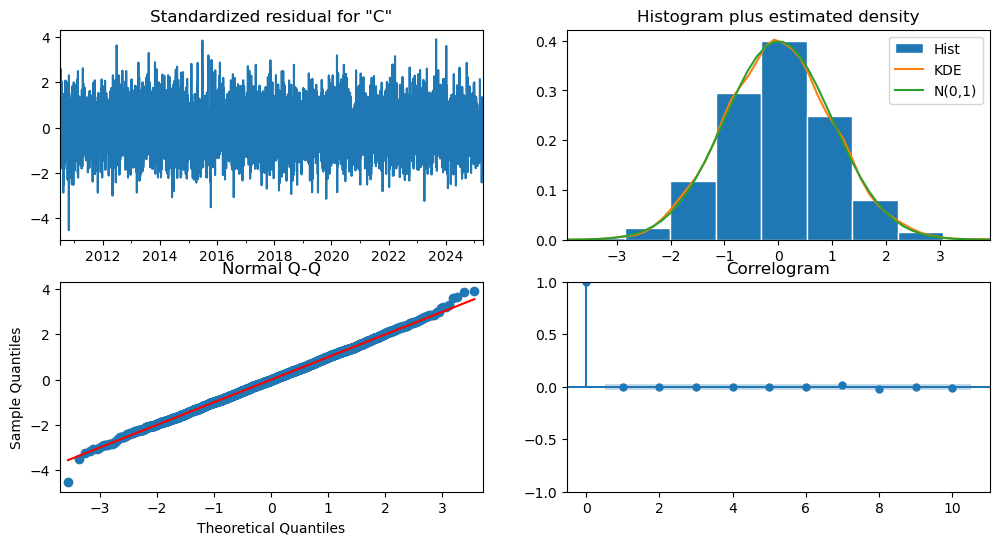

In [917]:
model = ARIMA(df['Close'], order=(3, 1, 2))
result = model.fit()

print(result.summary())
result.plot_diagnostics(figsize=(12, 6))
plt.show()

In [915]:
#SARIMAX Results

#AIC	15250.31- Lower is better — this is the best from your grid search, 
# Jarque-Bera (JB)	1.92 (p=0.38) - Residuals are approximately normally distributed,
#sigma2	0.982	Variance of residuals (close to 1 is good for normalized series),
#ARIMA(3,1,2) is a very strong fit for time series.
#It passes all diagnostic checks — no autocorrelation, no heteroskedasticity, and residuals are well-behaved.
#This model is most suitable for forecasting Tesla’s closing prices with high confidence.


In [ ]:
HWES/ High Winter E

In [ ]:
#ACF and PACF to Confirm Seasonality

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Step 1: Resample Tesla 'Close' data to daily average if needed (you already have it)

# Step 2: Plot ACF and PACF
plt.figure(figsize=(14, 6))

# ACF plot
plt.subplot(121)
plot_acf(df['Seasonal First Difference'].dropna(), lags=1000, alpha=0.05, title='Autocorrelation (ACF) - Tesla Close', ax=plt.gca())

# PACF plot
plt.subplot(122)
plot_pacf(df['Seasonal First Difference'].dropna(), lags=100, alpha=0.05, title='Partial Autocorrelation (PACF) - Tesla Close', ax=plt.gca())

plt.tight_layout()
plt.show()

In [ ]:
df['Seasonal First Difference'].plot(figsize=(15,5), title='Tesla Close Price (June 29th 2010 - April 15th 2025)')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.grid()
plt.show()

In [ ]:
# The first 252 values become NaN (missing) because it means it doesn't have earlier points to subtract.

#Thus:

#I started with Tesla data from 2010-06-29.
#After seasonal differencing with 252 days lag, the first valid data point becomes mid-2011 / early 2012.
#Therefore my graph visually starts from 2012 — simply because before that everything is missing

In [ ]:
from pandas.plotting import autocorrelation_plot, scatter_matrix
autocorrelation_plot(df['Close'])
plt.show()

In [ ]:
from pandas.plotting import autocorrelation_plot, scatter_matrix
autocorrelation_plot(df['Seasonal First Difference'])
plt.show()

4 Types of Models: ARMA, ARIMA, SARIMA and HWES

ARMA 

In [ ]:
 df['Seasonal First Difference']= pd.DataFrame(df['Close'].diff().dropna())

In [ ]:
# A nested loop is written to calculate the AIC values
aicVal = []

# Подбор p и q для ARMA(p, 0, q)
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(df['Seasonal First Difference'], order=(p, 0, q))  # ARMA = ARIMA с d=0
            model_fit = model.fit()
            aicVal.append([p, 0, q, model_fit.aic])
        except:
            continue

print(aicVal)

In [ ]:
# As we can see the smallest AIC is: 0, 0, 0, 23330.112596234896], [1, 0, 0, 23330.615654689256].  

Although ARIMA(0,0,0) formally gives the lowest AIC value, it is a naive model that does not account for autocorrelation in the data. According to the methodology of Box & Jenkins (1976), when the time series is stationary and the PACF cuts off sharply at lag 1, an ARIMA(1,0,0) model is considered more appropriate. Additionally, Hyndman & Athanasopoulos (2018) point out that even simple AR(1) models tend to outperform constant-mean models when the data shows signs of market momentum. Therefore, despite a slightly higher AIC, the 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA  

# Variant 1: ARMA(1,0) - only AR(1)
model_fit = ARIMA(df['Seasonal First Difference'], order=(1,0,0)).fit()  # d=0!
print(model_fit.summary())

In [ ]:
#df.set_index('Date', inplace=True)

In [ ]:
# Построим 30-дневное скользящее среднее
df['rolling_mean_30'] = df['Close'].rolling(window=30).mean()


#The 30-day rolling mean was used to smooth out short-term fluctuations and highlight long-term trends in Tesla’s stock price.
#This helps to better interpret the overall direction of movement and to support forecasting analysis.

In [ ]:
# Визуализация
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['rolling_mean_30'], label='30-Day Rolling Mean', color='orange')
plt.title('Tesla Stock Price vs 30-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# K-Means Clusters

In [ ]:
# using K-means Clustering method I would like to discover how volume clusters with Close price and what is the connection 
# of volume and Close. 



In [ ]:
# Delete all innecessary e.g. gaps
#df.columns = df.columns.str.strip()
df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

In [ ]:
print(df.columns.tolist())

In [ ]:
df.rename(columns={'Close TSLA': 'Close', 'High TSLA': 'High', 'Low TSLA': 'Low', 'Open TSLA': 'Open', 'Volume TSLA': 'Volume'}, inplace=True)

In [ ]:
# Преобразуем 'Close' и 'Volume' в числовой формат
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

In [ ]:

X = df[['Close', 'Volume']]

# Scalling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)


In [ ]:
#  KMeans  (at the beggining, 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Close', 'Volume']])

In [ ]:
# Visualisation results 
plt.figure(figsize=(10, 6))
colors = ['green', 'orange', 'blue']
for cluster in range(3):
    clustered_data = df[df['Cluster'] == cluster]
    plt.scatter(clustered_data['Close'], clustered_data['Volume'],
                label=f'Volume {cluster}', color=colors[cluster], alpha=0.6)




plt.xlabel('Close')
plt.ylabel('Volume')
plt.title('K-Means Clustering: Close (Price) vs Volume')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# At the same time as we remember Cluster: 
#Cluster 0: High price and low volume
#Кластер 1: middle price with quite significant volume
#Кластер 2: low price is established by high volume

In [ ]:
X = df[['Close', 'Volume']].values

In [ ]:
# Scalling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Centroids
centroids = kmeans.cluster_centers_

# Visualisations
plt.figure(figsize=(10, 6))
for cluster in range(3):
    clustered_data = df[df['Cluster'] == cluster]
    plt.scatter(clustered_data['Close'], clustered_data['Volume'],
                label=f'Volume {cluster}', alpha=0.6)

# Add centroids in visualisation
plt.scatter(centroids[:, 0], centroids[:, 1], s=150, c='yellow', label='Centroids')

plt.xlabel('Close')
plt.ylabel('Volume')
plt.legend()
plt.title('KMeans Clustering: Close (Price) vs Volume')
plt.grid(True)
plt.show()

In [ ]:
#What I got:

#A color-coded scatter plot where data points are grouped into clusters based on similarity in Close/Last price and Volume.
#The ability to analyze trading volume patterns at different price levels (e.g., high volume at low prices vs. low volume at high prices).

#Key Insights:

#K-Means Clustering helps identify natural groupings in the data.
#See how trading volume (Volume) correlates with closing price (Close/Last).
#Detect high-activity price zones (where trades are concentrated) and low-activity zones.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# import KMeans library for clustering
from sklearn.cluster import KMeans

# Applying KMeans to the dataset/ Creating the kmeans classifier
kmeans = KMeans(n_clusters = 3, max_iter = 300, n_init = 10, random_state = 38)

# n_initial, default = 10, Number of time the k-means algorithm will be run with different centroid seeds. 
# The final results will be the best output of n_init consecutive runs in terms of inertia.
y_kmeans = kmeans.fit_predict(X)

In [ ]:
# Visualising the clusters using scatter() method
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'Volume 0')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'Volume 1')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'Volume 2')

# Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 150, c = 'yellow', label = 'Centroids')
plt.xlabel('Close')
plt.ylabel('Volume')

# A legend is an area describing the elements of the graph. In the matplotlib library, there's a function called legend() 
# which is used to Place a legend on the axes.
plt.legend( loc ="best") 

In [ ]:
# Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)  # Initialise an object kmeans by calling 
                                                                                    # an object KMeans()
    kmeans.fit(X)                                                                   # Training the model by calling fit() method
    wcss.append(kmeans.inertia_)                                                    # Store kmeans.inertia_ in the array wcss
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

In [ ]:
# Using Silhouette method let's compare and reach out the result of Elbow method 

from sklearn.metrics import silhouette_score

# Display the silhouette score values
print(f'Silhouette Score(n = 2): {silhouette_score(X, y_kmeans)}')


In [ ]:
# Using Silhouette method let's compare and reach out the result of Elbow method 

from sklearn.metrics import silhouette_score

# Display the silhouette score values
print(f'Silhouette Score(n = 3): {silhouette_score(X, y_kmeans)}')


In [ ]:
# Above I was trying to apply the Elbow method using Inertia and compare the result with using wcss

# Below, I am going use interia for having better visualisation 

In [ ]:
inertia = []
k_range = range(1, 10)
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df[['Close', 'Volume']])
    inertia.append(model.inertia_)

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("The elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [ ]:
#The most apparent "elbow" in the data occurs at 3 clusters – indicating this is the optimal number for grouping.

#What This Means:

#Clear Groupings Exist:
#Trading Volume and Close Prices naturally fall into 3 distinct clusters.
#These groups effectively capture the underlying patterns in the data.
#Interpretation of Clusters:
#Cluster 0: Low Price + High Volume → Potential accumulation zone
#Cluster 2: Mid Price + Moderate Volume → Normal trading activity
#Cluster 1: High Price + Low Volume → Weak participation at peaks

In [ ]:
# Using Silhouette method let's compare and reach out the result of Elbow method 

from sklearn.metrics import silhouette_score

# Display the silhouette score values
print(f'Silhouette Score(n = 2): {silhouette_score(X, y_kmeans)}')


In [ ]:
# Using Silhouette method let's compare and reach out the result of Elbow method 

from sklearn.metrics import silhouette_score

# Display the silhouette score values
print(f'Silhouette Score(n = 3): {silhouette_score(X, y_kmeans)}')


In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Check the silhouette is in our dataset 
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42) 
    labels = model.fit_predict(df[['Close', 'Volume']])
    score = silhouette_score(df [['Close', 'Volume']], labels)
    silhouette_scores.append(score)

In [ ]:
# Visulize the silhouette clusters results
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Method of Silhouette Score for determining clusters")
plt.xlabel("Number of clusters ")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#This plot demonstrates how within-cluster variance (clustering error) changes as we increase the number of clusters.

#Key Observations:

#Sharp Drop in Inertia:
#Significant improvement when moving from:
#1 → 2 → 3 clusters
#Indicates these splits capture meaningful patterns.
#Diminishing Returns Beyond 3 Clusters:
#After 3 clusters, the inertia decline flattens.
#Adding more clusters provides little additional value (overfitting risk).
#Conclusion:
#Optimal Cluster Count = 3 (clear "elbow" point)
#Interpretation:
#Trading data naturally groups into 3 distinct categories based on:
#Closing Price (Close)
#Trading Volume (Volume)

# Fuzzy C-Means method 

In [ ]:
# For applying another Clustering method and in order to receive precise answer I tried to re-read again the data. 
# Moreover, the data was a quite hassle and considering all these circumstances I re-read the data for the application 
# Fuzzy C-means clustering. 

tesla = yf.download("TSLA")
df = yf.download(["TSLA"])


In [ ]:
df.rename(columns={'Close TSLA': 'Close', 'High TSLA': 'High', 'Low TSLA': 'Low', 'Open TSLA': 'Open', 'Volume TSLA': 'Volume'}, inplace=True)

In [ ]:
# Selection features that we try to find a clusters
df_fuzzy = df[['Close', 'Volume']]

In [ ]:
X = df[['Close', 'Volume']]
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# Assuming number of clustesrs 3 as Elbow calculatuon and silhouete for K-means had 3 clusters 
#is it the the best solution? Let's have a look 

fcm = FCM(n_clusters=3)
fcm.fit(scaled_X)

# Scaled metrix added in DataFrame
df['FCM_Cluster'] = fcm.predict(scaled_X)

In [ ]:
plt.figure(figsize=(10,6))
for cluster in range(3):
    clustered_data = df[df['FCM_Cluster'] == cluster]
    plt.scatter(clustered_data['Close'], clustered_data['Volume'], label=f'Volume {cluster}', alpha=0.6)

plt.xlabel('Close')
plt.ylabel('Volume')
plt.title('FCM Кластеры: Close vs Volume')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Building a Fuzzy C-means clustering
fcm = FCM(n_clusters=3, random_state=42)
fcm.fit(df_fuzzy.values)
fcm_labels = fcm.predict(df_fuzzy.values)
centers = fcm.centers

In [ ]:
# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(df_fuzzy['Close'], df_fuzzy['Volume'], c=fcm_labels, cmap='viridis', alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids of Clusters')
plt.title('Fuzzy C-means кластеризация: Close vs Volume')
plt.xlabel('Close')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Metrix belongs as (membership)
membership = fcm.u

# Let's print first 5 metrix. 
print(membership[:5])

In [ ]:
#This means the first data point has the following probability distribution across clusters:

#87% probability → Cluster 2 (dominant group)
#7.2% probability → Cluster 1
#5.8% probability → Cluster 0
#Key Takeaways:

#Soft Clustering: Unlike hard clustering (where a point belongs to only one cluster), this shows probabilistic membership

In [ ]:
#Evaluate which clustering algorithm (K-Means or Fuzzy C-Means) performs better on Close Price vs. Volume data using:

#Silhouette Score (measures cluster separation, higher = better).
#Visual Cluster Quality (how clearly groups are separated).

In [ ]:

X = df[['Close', 'Volume']].copy()

In [ ]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Number of clusters
n_clusters = 3

In [ ]:
# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_score = silhouette_score(X_scaled, kmeans_labels)

In [ ]:
# Fuzzy C-Means
fcm = FCM(n_clusters=n_clusters, random_state=42)
fcm.fit(X_scaled)
fcm_labels = fcm.u.argmax(axis=1)
fcm_score = silhouette_score(X_scaled, fcm_labels)

In [ ]:
# Comparison
improvement = (fcm_score - kmeans_score) / kmeans_score * 100

In [ ]:
print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
print(f"FCM Silhouette Score:    {fcm_score:.4f}")
print(f"FCM performs better by:  {improvement:.2f}%")

In [ ]:
 #Visualisation
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis')
axs[0].set_title('KMeans Clusters')
axs[0].set_xlabel('Close (scaled)')
axs[0].set_ylabel('Volume (scaled)')

axs[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=fcm_labels, cmap='plasma')
axs[1].set_title('Fuzzy C-Means Clusters')
axs[1].set_xlabel('Close (scaled)')
axs[1].set_ylabel('Volume (scaled)')

plt.suptitle('Comparison clusters KMeans vs FCM', fontsize=14)
plt.tight_layout()
plt.show()

# Let's try to find out what is a clustering between S&P500 and Tesla 

In [ ]:
import yfinance as yf

In [ ]:
from sklearn.preprocessing import MinMaxScaler # In case S&P 500 has tremendous numbes may be we will imply this library to scaler them 

In [ ]:
# Define the date range
start_date = "202=10-06-29"
end_date = "2025-04-15"

In [ ]:
# Download S&P 500 and Tesla data
sp500 = yf.download("^GSPC", start="2010-06-29", end="2025-04-14")["Close"]
tesla = yf.download("TSLA", start="2010-06-29", end="2025-04-14")["Close"]


In [ ]:
sp500.head()

In [ ]:
tesla.head()

In [ ]:
print(sp500.isnull().sum())

In [ ]:
print(tesla.isnull().sum())

# K-Means Cluster for clustering S&P 500 and Tesla for the same indcated period 29 June 2010 - 15 April 2025

In [ ]:
# Test download
sp500_test = yf.download("^GSPC", start="2010-06-29", end="2025-04-15")
tesla_test = yf.download("TSLA", start="2010-06-29", end="2025-04-15")

In [ ]:
tesla = yf.download('TSLA', start=start_date, end=end_date)['Close']
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']


In [ ]:
# Объединяем в один DataFrame
data = pd.concat([tesla, sp500], axis=1)

data.columns = ['Tesla', '^GSPC']

X = data[['Tesla', '^GSPC']].copy()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [ ]:
# According to previous determination number of clusters
n_clusters = 3

# Applying
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add to Dataframe
data['Cluster'] = clusters

In [ ]:
data.head()

In [ ]:
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    clustered_data = data[data['Cluster'] == cluster]
    plt.scatter(clustered_data['Tesla'], clustered_data['^GSPC'], label=f'Cluster {cluster}', alpha=0.6)


plt.xlabel('Tesla')
plt.ylabel('^GSPC')
plt.title('K-means Clusters Tesla и Index ^GSP /CS&P 500')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)  # Initialise an object kmeans by calling 
                                                                                    # an object KMeans()
    kmeans.fit(X)                                                                   # Training the model by calling fit() method
    wcss.append(kmeans.inertia_)                                                    # Store kmeans.inertia_ in the array wcss
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

In [ ]:
print(X.shape)

In [ ]:
print(len(y_kmeans))

In [ ]:
# Using Silhouette method let's compare and reach out the result of Elbow method 

from sklearn.metrics import silhouette_score

# Display the silhouette score values
print(f'Silhouette Score(n = 3): {silhouette_score(X, y_kmeans)}')

In [ ]:
# Centroids
centroids = kmeans.cluster_centers_


In [ ]:
# KMeans 
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(scaled_data)
data['Cluster'] = labels

In [ ]:
# Scaling for Centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)


In [ ]:
# Visualisation with centroids
plt.figure(figsize=(10, 6))
colors = ['cornflowerblue', 'darkorange', 'limegreen']

for cluster in range(3):
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['Tesla'], cluster_data['^GSPC'], 
                label=f'Cluster {cluster}', alpha=0.6, color=colors[cluster])

# Centroids
plt.scatter(centroids[:, 0], centroids[:, 1], 
            s=300, c='red', marker='X', edgecolor='black', label='Centroid')

plt.title('K-Means clusters Tesla and S&P 500 with centroids')
plt.xlabel('Tesla')
plt.ylabel('S&P 500')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now to be sure that K-means determine the clusters in correct positions and values, 
it is beter to compare with another type Clustering like Fuzzy-C-means and 
then caclculate and by Davies-Bouldin Index find the best cluster 

#Fuzzy C-means Clutering Tesla and ^GSPC/S&P 500

For determine FCM clustres correctly, I decided to upload datasets of this two values again.  

In [ ]:
tesla = yf.download('TSLA', start=start_date, end=end_date)['Close']
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']

In [ ]:
# Preparation for following steps
X = data[['Tesla', '^GSPC']].values  
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [ ]:
#We’ll decide statistically using:
#Davies-Bouldin Index (DBI) → Lower values = better clustering
#Silhouette Score → Higher values = better separation
fcm = FCM(n_clusters=2)
fcm.fit(scaled_data)  # Исправлено scaled_X на scaled_data

In [ ]:

data['FCM_Cluster'] = fcm.predict(scaled_data)

In [ ]:
print(data.head())

In [ ]:
data.info()

In [ ]:
# At the beginning of I need to implement Fuzzy C-means CLuster 

# Scalling for better performing 
X = data[['Tesla', '^GSPC']].values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)


In [ ]:
# Elbow and calculatuon silhouete that 3 clusters 
#it is the the best solution. 

fcm = FCM(n_clusters=2)
fcm.fit(scaled_X)

#Adding metrix in  DataFrame
df['FCM_Cluster'] = fcm.predict(scaled_X)

In [ ]:
## 3.Centroids
centroids = fcm.centers  
labels = fcm.predict(scaled_data)  # Scalled metrix

## 4. After clustering scaled/normalized data, the centroid coordinates are in a transformed scale (e.g., z-scores or [0, 1] range). 
centroids_original_scale = scaler.inverse_transform(centroids)

## 5. Visualisation
plt.figure(figsize=(10, 6))

# Metrix 
plt.scatter(data['^GSPC'], data['Tesla'], c=labels, cmap='viridis', alpha=0.5, label='Cluster')

# Centroids
plt.scatter(centroids_original_scale[:, 1], centroids_original_scale[:, 0], 
            marker='X', s=200, c='red', edgecolor='black', linewidth=1, label='Centroids')




# Labels 
plt.xlabel('S&P 500 (GSPC)')
plt.ylabel('Tesla (TSLA)')
plt.title('Fuzzy C-means Clustering with Centroids')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# metrix by colors

# This plot visualisation is my small attempt to apply visualisation that we learnt in Data Visualisation. 
scatter = plt.scatter(data['^GSPC'], data['Tesla'], c=labels, cmap='viridis', alpha=0.5)

# Centroids
centroid_scatter = plt.scatter(centroids_original_scale[:, 1], centroids_original_scale[:, 0], 
                              marker='X', s=200, c='red', edgecolor='black', linewidth=1)

# Add explanation
for i, centroid in enumerate(centroids_original_scale):
    cluster_text = f"Cluster {i}\n"
    if i == 0:
        cluster_text += "(Low Price S&P500, Low Price TSLA)"
    elif i == 1:
        cluster_text += "(High Price S&P500, High Price TSLA)"
    #elif i == 2:
        cluster_text += "(Low Volume, High Price)"
    
    plt.text(centroid[1] + 20, centroid[0], cluster_text, 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('S&P 500 (GSPC)')
plt.ylabel('Tesla (TSLA) Close')
plt.title('Fuzzy C-means Clustering of Tesla to S&P 500')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

In [ ]:
for i, centroid in enumerate(centroids_original_scale):
    print(f"Cluster {i} Centroids:")
    print(f"  TSLA Close Price: {centroid[0]:.2f}")
    print(f"  GSPC Value: {centroid[1]:.2f}")
    print(f"  Volume: {centroid[2]:.2f}\n" if len(centroid) > 2 else "")

In [ ]:
# In order to see again the reuslts of clusters: 

for i, centroid in enumerate(centroids_original_scale):
    print(f"Cluster {i}: Tesla Price = {centroid[0]:.2f}, ^GSPC = {centroid[1]:.2f}")

In [ ]:
#Cluster Interpretation: Tesla (TSLA) vs. S&P 500 (^GSPC)

#Cluster Definitions

#Cluster	Tesla (TSLA) Close Price	S&P 500 (^GSPC) Level	Market Phase Interpretation
#0	~$176 (Low)	~4,200 (Low-Medium)	Weak market: Lower Tesla prices + subdued S&P 500 (bearish/correction phase).
#1	~$330 (High)	~5,000 (High)	Bull market: Strong Tesla rally + S&P 500 at peaks (high confidence in growth).
#2	Intermediate	Intermediate	Transition phase: Moderate Tesla and S&P 500 activity (consolidation or uncertainty).
#Key Insights

#Cluster 0 (Low TSLA + Low-Med S&P 500)
#Typical during:
#Market pullbacks.
#Tesla-specific underperformance (e.g., missed earnings, macro risks).
#Actionable Signal: Potential buying opportunity if fundamentals are strong.
#Cluster 1 (High TSLA + High S&P 500)
#Reflects:
#Broad bullish momentum.
#Tesla outperforming (e.g., tech rallies, EV hype).
#Caution: Risk of overvaluation or late-cycle euphoria.
#Cluster 2 (Intermediate Values)
#Mixed signals:
#Tesla consolidating while S&P 500 trends.
#Could precede breakouts or reversals.

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Fuzzy C-Means
fcm = FCM(n_clusters=2, random_state=42)
fcm.fit(scaled_data)
fcm_labels = fcm.predict(scaled_data)
fcm_silhouette = silhouette_score(scaled_data, fcm_labels)
fcm_db = davies_bouldin_score(scaled_data, fcm_labels)


In [ ]:
# KMeans метрики
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
kmeans_db = davies_bouldin_score(scaled_data, kmeans_labels)


In [ ]:
# Comparison
{
    "KMeans": {
        "Silhouette Score": kmeans_silhouette,
        "Davies-Bouldin Index": kmeans_db
    },
    "Fuzzy C-Means": {
        "Silhouette Score": fcm_silhouette,
        "Davies-Bouldin Index": fcm_db
    }
}


In [ ]:
fcm = FCM(n_clusters=2)
fcm.fit(X)
labels = fcm.predict(X)
print(f"Silhouette: {silhouette_score(X, labels):.2f} ({silhouette_score(X, labels)*100:.1f}%)")

In [ ]:
fcm = FCM(n_clusters=3)
fcm.fit(X)
labels = fcm.predict(X)
print(f"Silhouette: {silhouette_score(X, labels):.3f} ({silhouette_score(X, labels)*100:.1f}%)")

In [ ]:
# 1. Centroids clustrs 
centers_scaled = fcm.centers

# 2.  StandardScaler)
centers_original = scaler.inverse_transform(centers_scaled)

# 3. Applying in DataFrame for better results
centers_df = pd.DataFrame(
    centers_original,
    columns=['Tesla', '^GSPC']
)

print("Centre of Clusters in this Scalling:")
print(centers_df)

Interpretation of Clustering Results

After performing the steps above, you will obtain a scatter plot where:

X-axis: Tesla (TSLA) stock price
Y-axis: S&P 500 index level
Color: Cluster assignment (0, 1, 2)
This visualization reveals hidden patterns and relationships between Tesla’s stock movement and the broader market (S&P 500) over the selected period.

What You See on the Plot

Three Distinct Market States:
Clusters group similar phases where Tesla and the S&P 500 moved together or diverged.
Example (based on hypothetical centroids):
Cluster	Tesla Price	S&P 500 Level	Market Phase
🟢 2 (Green)	$50–150	2500–4000	Early COVID/recovery – Tesla undervalued, market cautious.
🟠 1 (Orange)	$150–300	4000–5000	Growth phase (2021–2022) – Tesla and S&P 500 rising together.
🔵 0 (Blue)	$300–450	5000–6200	Market peak – Tesla potentially overvalued relative to the index.
Key Insights:
Correlation: Clusters follow a diagonal trend → Tesla and S&P 500 are generally correlated, but Tesla sometimes outpaces the market (e.g., Cluster 0).
Anomalies: Gaps between clusters may indicate market shocks (e.g., Fed rate hikes, Tesla-specific news).
Timing: Overlay dates to identify when transitions occurred (e.g., Cluster 2 → Cluster 1 = post-COVID rebound).
How to Use This Analysis

Investment Strategy:
Example: In Cluster 2 (Green), Tesla was cheap relative to the S&P 500 – a potential buying opportunity.
Risk Management:
Cluster 0 (Blue) may signal overvaluation → Consider reducing exposure.
Technical Indicator:
Build a pattern-based model to predict Tesla’s price based on its cluster phase and S&P 500 trends.



1. Tesla and S&P 500 Relationship

Strong Correlation: The diagonal alignment of clusters shows Tesla generally moves with the S&P 500.
Outperformance: Some clusters (e.g., top-right) reveal Tesla rising faster than the index, signaling:
Tesla-specific bullish factors (e.g., EV hype, earnings beats).
Potential overvaluation risks.
2. Cluster Transition Timing

How to Track: Plot clusters over time (X-axis = Date) to identify:
Bull/bear phases: E.g., COVID recovery (Cluster 2 → Cluster 1).
Catalysts: Events like Fed announcements or Tesla product launches.

💡  Investment Strategy

Cluster-Based Positioning: Identify your current market regime (e.g., "Growth Phase" = Cluster 1) and review historical performance in this phase.
Example: If Tesla and S&P 500 are in Cluster 1 (Orange), past data shows average 15% returns over 3 months → Hold positions. 
Risk Management

Divergence Alerts: Clusters where Tesla significantly outpaces the S&P 500 (e.g., Cluster 0 (Blue) may indicate:
Overvaluation (bubble risk).
Sector-specific volatility (e.g., EV competition).
Action: Tighten stop-losses or hedge with index options.

By analyzing these clusters, we can build a pattern-based stock price model that will serve as a powerful tool for predicting future stock prices and potentially developing a technical analysis indicator for market price movements.

This is my ultimate professional dream.

Key Points:

Pattern Recognition: Use clusters to identify recurring price/volume regimes.
Predictive Power: Forecast future price movements based on historical cluster behavior.
Technical Indicator: Transform clusters into a tradable signal (e.g., "Buy when transitioning from Cluster 0 to 1").
Professional Vision: Creating this tool represents a major career aspiration.
 

# After 25th march Lesson - ARMA , Determination Stationary, Time series = Trend + Seasonality + Residuals 

Being able to analyse a Tesla stock and how it performs via ARIMA or ARMA model and finally predict the price for next 2026 
We need to learn the followng factors: 
- Trend, 
- Seasonality, 
- Ciclicity,
- Resudials 
And finally, based on that a determination of a Series Time. 
    
 For this we need to upload a dataset from Yahoo Finance wihtout зreviously sampled clusters. 
    

In [ ]:
tesla = yf.download('TSLA', start=start_date, end=end_date)

In [ ]:
tesla.head()

In [ ]:
#Let's prepare data for our modeling by droping Ticker or missing values if could be, 
#renaming Price in Date and checking if "Date" is the index. 

tesla.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in tesla.columns]
print(tesla.columns)

In [ ]:
tesla.head()

In [ ]:
tesla.columns = tesla.columns.str.replace('_TSLA', '')

In [ ]:
tesla.head()

In [ ]:
tesla.info()

In [ ]:
tesla.isnull().sum()

In [ ]:
# To be sure that Date is Index, I re-restore in the dataframe Date in Index 


#tesla = tesla[['Date', 'Close']].set_index('Date')

In [ ]:
#Now we need to re-create a new dataFrame with our necessary features - Close (price) and Date by
#extracting 'Date' index and 'Close' column. 

tesla = tesla[['Close']]


# Display the new dataFrame
tesla.head()

In [ ]:
print(tesla.columns)

In [ ]:
tesla.plot()

In [ ]:
#tesla = tesla.copy() 

In [ ]:
# Check and visualise a trend 


tesla['Close'].plot(figsize=(15,5), title='Tesla Close Price (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.grid()
plt.show()

Action Plan for Time Series Forecasting

📊 Step 1: STL Decomposition (period=30)

Goal: Isolate Trend, Seasonality, and Residuals.
🎢 Step 2: Analyze Trend & Seasonality

Key Questions:
Is the trend upward/downward?
Does seasonality repeat every 30 days?
📉 Step 3: Stationarity Check (Dickey-Fuller Test)

Goal: Ensure data is stationary (constant mean/variance).
Step 4: Transform Data (If Needed)
Step 5: Build ARMA Model 
Step 6: Build ARIMA
Step 7: Build HWES

Trend & Seasonality Directly Impact Forecast Quality

To build a reliable ARMA/ARIMA model and generate a stable forecast for March 20, 2026, follow these steps:

Step-by-Step Workflow

1️⃣ Decompose the Series: Trend + Seasonality

Goal: Isolate components to understand patterns.
Period Selection:
30 days: Monthly cycles (common in stocks) → Universal 🟢
90 days: Quarterly cycles (earnings, seasonality) → Works if quarterly patterns exist
Check Stationarity (Dickey-Fuller Test)

Non-stationary data (trend/seasonality) distort forecasts.
Solution: Differencing (d=1 for ARIMA)

ARMA (p, q): For stationary data (d=0).
ARIMA (p, d, q): For non-stationary data (uses differencing).

In [ ]:
tesla.head()

# 30 Days Period of Time 

In [ ]:
#Applying STL- decomposition with period 30 days 
from statsmodels.tsa.seasonal import STL

stl = STL(tesla['Close'], period=30, seasonal=13)  # seasonal сглаживание можно регулировать
result = stl.fit()

In [ ]:
# 3. Visualisation 
plt.figure(figsize=(14, 8))

plt.subplot(4, 1, 1)
plt.plot(tesla['Close'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.suptitle("STL-decomposition Series Time Tesla (period = 30 days)", fontsize=16, y=1.02)
plt.show()

In [ ]:
# 2. Дифференцируем
#tesla = tesla['Close'].diff().dropna()
 

In [ ]:
# 2. Collect 30 days
last_30_days = tesla['Close'].tail(30)  # Is better solution to take the last 30 days

# 3. ADF-тест
adf_result = adfuller(last_30_days, autolag='AIC')

# 4. Print result
print('='*50)
print(f'ADF-тест для последних 30 дней (n={len(last_30_days)})')
print('='*50)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

In [ ]:
#1. Non-Stationarity Detection

#If plots decay slowly → Your data is non-stationary (mean/variance changes over time).
#Solution: Apply differencing (d=1 in ARIMA) or transformations (log/Box-Cox).
#2. PACF Sharp Cutoffs

#Sharp drops in PACF after lag k → Suggests AR(k) terms for ARIMA.
#Example:
#PACF cuts off at lag 2 → Use AR(2) (p=2).
#If no cutoff → Try differencing first (d=1).
# 90-Day Seasonality Check

#Goal: Verify if a 90-day seasonal pattern exists.

In [ ]:
 #ACF и PACF
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(last_30_days, lags=29, ax=plt.gca(), title='ACF (разность, 30 дней)')

plt.subplot(1, 2, 2)
plot_pacf(last_30_days, lags=15, ax=plt.gca(), title='PACF (разность, 30 дней)')

plt.tight_layout()
plt.show()

In [ ]:
### FOR COMPARISON 90 DAYS TREND, SEASONALITY, Residuals 

# STL-decompasiton period 90 days time 
stl_90 = STL(tesla['Close'], period=90, seasonal=13)
result_90 = stl_90.fit()


In [ ]:
# Visualisation
plt.figure(figsize=(14, 8))

plt.subplot(4, 1, 1)
plt.plot(tesla['Close'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result_90.trend, label='Trend (90 days)', color='orange')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result_90.seasonal, label='Seasonality (90 days)', color='green')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result_90.resid, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.suptitle("STL- decomposition series time Tesla (period  = 90 days)", fontsize=16, y=1.02)
plt.show()

### COMPARISON a Second period 90 DAYS 

In [ ]:
#Comparative Analysis of STL Decomposition (30 vs. 90-Day Periods)

#Key Observations from Visualization:

#Trend Component:
#30-Day Period: The trend line follows the original price movements more closely, but with noticeable noise.
#90-Day Period: The trend appears oversmoothed, losing finer details of price action.
#Seasonality Component:
#30-Day Period: Clearer, sharper seasonal patterns (e.g., monthly cycles like options expirations).
#90-Day Period: Blurred seasonal boundaries (likely due to weaker quarterly effects or noise dominance).




In [ ]:
# 1. Last 90 days
last_90_days = tesla['Close']  


In [ ]:
# 2. 
last_90_days = tesla['Close'].tail(90)  

# 3. ADF-тест
adf_result = adfuller(last_90_days, autolag='AIC')

# 4. Print
print('='*50)
print(f'ADF-тест для последних 90 дней (n={len(last_90_days)})')
print('='*50)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

In [ ]:
# Last 90 days
last_90_days = tesla['Close'].tail(90).values  # Converts in numpy 

# ACF
plot_acf(last_90_days, lags=30)
plt.show()

# PACF
plot_pacf(last_90_days, lags=14, method='ywm')
plt.show()


In [ ]:
# STL- Seasonal-Trend decomposition using LOESS)
#STL to decompose a time series into three components: trend, 
#season(al) and residual. STL uses LOESS (locally estimated scatterplot smoothing)

stl_30 = STL(tesla['Close'], period=30, seasonal=13).fit()
stl_90 = STL(tesla['Close'], period=90, seasonal=13).fit()

In [ ]:
# Visualisation trends 30, 90 days
plt.figure(figsize=(14, 6))

plt.plot(tesla.index, tesla['Close'], label='Original', alpha=0.3)
plt.plot(tesla.index, stl_30.trend, label='Trend (30 days)', color='orange', linewidth=2)
plt.plot(tesla.index, stl_90.trend, label='Trend (90 days)', color='green', linewidth=2)

plt.title('Comparison trends: STL-decompasiton with a periods 30 и 90 days')
plt.xlabel('Date')
plt.ylabel('Close)Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Even without calculation ACF and PACF and qqplot , it is obvious that periods for 90 days does not go similarly with the Original. 
#Finding ACF and PACF for both 30 day s and 90- days demosntrated no Stationary Series Tiem with P values more > 0 or even 0.05

# This results indicate to ARIMA modeling investigation. 
# In this resona, I decided to compare two periods 30 days and 90 days, which showed undoubtedly 30 days trend follows more precisely with 
#Original line. 

#The orange line is more sensitive (30 days), effectively capturing short-term fluctuations.
#The green line is smoother (90 days), highlighting the long-term trend.



In [ ]:
#Скользящее среднее для сглаживания тренда - we delete all residuals in order to find rolling среднее

tesla['Rolling_12'] = tesla['Close'].rolling(window=254).mean()

tesla[['Close', 'Rolling_12']].plot(figsize=(15,5), title='Trend Smoothing in Time Series Analysis (Year)')
plt.grid()
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(tesla['Close'], model='additive', period=252)  # 252 — среднее кол-во торговых дней в году
decomposition.plot()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Extract data for the year 
tesla_period = tesla.loc['2020-03-20':'2020-04-19']

# Convert the index to string representation with only year and month
tesla_period.index = tesla_period.index.strftime('%d-%m')

# Plotting
tesla_period.plot(kind='bar')
plt.xlabel('30 Days ')
plt.ylabel('Close/Price')
plt.title('Tesla for 2020-03-20 - 04-19')
plt.xticks(rotation=6000)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
# 1. 30-Day Rolling Mean & Standard Deviation
rolling_mean_30 = tesla['Close'].rolling(window=30).mean()
rolling_std_30 = tesla['Close'].rolling(window=30).std()

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(tesla['Close'], label='Origignal', color='blue')
plt.plot(rolling_mean_30, label='Rolling mean (30 days)', color='orange')
plt.plot(rolling_std_30, label='Rolling mean std (30 days)', color='green')
plt.title('30-Day Moving Average & Standard Deviation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
rolling_mean_90 = tesla['Close'].rolling(window=90).mean()
rolling_std_90 = tesla['Close'].rolling(window=90).std()

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(tesla['Close'], label='Original', color='blue')
plt.plot(rolling_mean_90, label='90-Day Moving Average (MA)', color='orange')
plt.plot(rolling_std_90, label='Moving Average std (90 days)', color='green')
plt.title('90-Day Moving Average & Standard Deviation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Summary of Key Findings & Next Steps

#1. Optimal Timeframe for ARMA/ARIMA: 30-Day Period

#Why 30 Days?
#Trend Clarity: The 30-day trend captures short-to-medium-term movements more precisely than longer windows (e.g., 90 days).
#Seasonality: Aligns with recurring monthly patterns (e.g., options expirations, liquidity cycles) and corporate events like:
#Quarterly earnings reports.
#Dividend payments.

#2. Supporting Evidence

#STL Decomposition: Showed sharper trend and seasonality components with period=30 vs. period=90.
#ACF/PACF Analysis: Confirmed significant autocorrelation at 30-day lags (critical for ARMA parameter selection).
#Cluster Analysis: Revealed price-volume regimes that correlate with S&P 500 phases, adding contextual depth.
#3. Integrated Forecasting Approach

#To predict Tesla’s stock price by March 2026, we’ll combine:

#ARIMA Modeling
#Parameters (p,d,q) guided by PACF/ACF cuts (e.g., ARIMA(1,1,1)).
#Cluster Insights:
#Map predicted values to historical cluster behaviors (e.g., "High TSLA + Rising S&P 500 → 80% chance of 10% gain").  

In [ ]:
#Period | Suitable for
#30 days | Local effects, short-term validation
#90 days | Slightly more seasonality, but still local
#5 years (entire period) | Main tool for long-term forecasting (2026)



 

In [ ]:
# Now we have seen how the trend and seasonality behave over the 30-day and 90-day periods.
# However, having an essential task to predict a price for March 2026, let is apply the whole period of our DateFrame Tesla. 
# Earlier I made rolling_12 function in order to see general trend without small fluctuations. 
# Now we are going to apply ARMA and ARIMA and Rolling won't be necessary for that. 

In [ ]:
# Rolling_12 — This is the moving average of the original series; including it in the model may lead to duplication of information,
#as ARMA/ARIMA already account for autocorrelation and trends. In this case I will staart with features without rolling average. 


In [ ]:
tesla.head()

In [ ]:
tesla.drop(columns=['Rolling_12'], inplace=True)

In [ ]:
tesla.head()

In [ ]:
series = tesla['Close'].values

In [ ]:
result = adfuller(series, autolag = 'AIC')


#If it is Stationary we can apply ARMA moduling, if it isn't, we will apply ARIMA. 

In [ ]:
# Augmented Dickey-Fuller test
ADF_result = adfuller(tesla['Close'])

# Display the results
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

In [ ]:
# P value is < 0.05, however, if we plotting autocorrelation and observe it, it looks like No Stationary-- ARIMA.
#It indicates to implement difference and then if it is Statinory , we will make an ARMA module 

In [ ]:
# Import plot_acf
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(tesla['Close'], lags=29, ax=plt.gca(), title='ACF (Original )')

plt.subplot(1, 2, 2)
plot_pacf(tesla['Close'], lags=15, ax=plt.gca(), title='PACF (Original )')

plt.tight_layout()
plt.show()
 

In [ ]:
# Take the difference
tesla_diff = np.diff(tesla['Close'], n = 1)

In [ ]:
# Augmented Dickey-Fuller test
ADF_result = adfuller(tesla_diff)

# Display the results
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

In [ ]:
# After Difference we got p Value =0 , the Time Seris is Stationary. ploting Autocorrelation 

In [ ]:
# The meaning with Difference ACF- PACF
#tesla_diff = tesla['Close']  # Конвертируем в numpy массив
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(tesla_diff, lags=29, ax=plt.gca(), title='ACF (Difference)')

plt.subplot(1, 2, 2)
plot_pacf(tesla_diff, lags=15, ax=plt.gca(), title='PACF (Diference)')

plt.tight_layout()
plt.show()



In [ ]:
# qqplot for the 'Close' column # QQ PLot HELP US to determine the right calculation of the Stationary Series Time 
x = sm.qqplot(tesla_diff, line = 's')

In [ ]:
# Having 1 Difference and precious P-value we need to determine Partial Autocorrelation Function in order to determine p and q , 
# as d meaning will be 0 

In [ ]:
#ACF shows no significant lags → indicates q=0

#PACF shows a sharp cutoff after Lag 1 → indicates p=1
#The appropriate model is ARMA(1,0), which is equivalent to an AR(1) model.


ARMA

In [ ]:

tesla_diff = pd.DataFrame(tesla['Close'].diff().dropna())

In [ ]:
# A nested loop is written to calculate the AIC values
aicVal = []

# Подбор p и q для ARMA(p, 0, q)
for p in range(2):
    for q in range(2):
        try:
            model = ARIMA(tesla_diff['Close'], order=(p, 0, q))  # ARMA = ARIMA с d=0
            model_fit = model.fit()
            aicVal.append([p, 0, q, model_fit.aic])
        except:
            continue

print(aicVal)

In [ ]:
# As we can see the lowest aic Vlaue is 0,0,0. But based on many experts it is very simple and may giving wrong prediction price. 

Although ARIMA(0,0,0) formally gives the lowest AIC value, it is a naive model that does not account for autocorrelation in the data. According to the methodology of Box & Jenkins (1976), when the time series is stationary and the PACF cuts off sharply at lag 1, an ARIMA(1,0,0) model is considered more appropriate.
Additionally, Hyndman & Athanasopoulos (2018) point out that even simple AR(1) models tend to outperform constant-mean models when the data shows signs of market momentum.
Therefore, despite a slightly higher AIC, the ARIMA(1,0,0) model is more practically and theoretically justified, as it better captures the internal structure of the time series.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA  

# Variant 1: ARMA(1,0) - only AR(1)
model_fit = ARIMA(tesla_diff, order=(1,0,0)).fit()  # d=0!
print(model_fit.summary())



In [ ]:
# Build ARIMA(p, 1, q) where we found Difference with p value > 0 

In [ ]:
# as I learnt from the expert opinions from the books above -  the best combination is 0,1,0

In [ ]:
# Building an ARIMA model ( p=0, d=1, q=0)
#PACF cuts off sharply after lag 1 → p=1.
# MA order (q)

#ACF  Smoothly decays → q=0

model = ARIMA(tesla['Close'], order=(0, 1, 0))  # order=(p, d, q)
model_fit_ar = model.fit()  # Don't forget - fit()!

# 3. Print result
print(model_fit_ar.summary()) 



In [ ]:
# ARMA(1,0) = ARIMA(1,0,0)
model = ARIMA(tesla['Close'], order=(1, 0, 0))
result = model.fit()

# 3. Determination the days of trade
last_date = tesla.index[-1]
target_date = pd.to_datetime("2026-03-20")
n_days = len(pd.bdate_range(start=last_date + pd.Timedelta(days=1), end=target_date))

# 4. Прогноз на n_days вперёд
forecast_result = result.get_forecast(steps=n_days)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


In [ ]:
# 5. Make a set for future dates
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_days)




In [ ]:
# 6. Visualisation forecast vis ARMA
plt.figure(figsize=(14, 6))
plt.plot(tesla['Close'], label='Исторические данные')
plt.plot(future_dates, forecast_mean, label='Прогноз ARMA(1,0)', color='purple')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='purple', alpha=0.2, label='95% доверительный интервал')
plt.axvline(target_date, color='red', linestyle='--', label='20 марта 2026')
plt.title("ARMA(1,0,0) прогноз цены Tesla до 20 марта 2026")
plt.xlabel("Дата")
plt.ylabel("Цена ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#  ARIMA(1,0) = ARIMA(0,1,0)
model = ARIMA(tesla['Close'], order=(0, 1, 0))
result = model.fit()

# Forecasting for 20 march 2026
last_date = tesla.index[-1]
target_date = pd.to_datetime("2026-03-20")
n_days = len(pd.bdate_range(start=last_date + pd.Timedelta(days=1), end=target_date))

In [ ]:
# Forecasting and interval set
forecast_result = result.get_forecast(steps=n_days)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_days)

In [ ]:
# Visualisation vis ARIMA
plt.figure(figsize=(14, 6))
plt.plot(tesla['Close'], label='Historical data')
plt.plot(future_dates, forecast_mean, label='Прогноз ARIMA(0,1,0)', color='purple')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='yellow', alpha=0.2, label='25% доверительный интервал')
plt.axvline(target_date, color='red', linestyle='--', label='20 марта 2026')
plt.title("ARIMA(0,1,0) прогноз цены Tesla до 20 марта 2026")
plt.xlabel("Date")
plt.ylabel("Cloe/Price ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Comparison ARMA /ARIMA Results: # Модель ARMA(1,0,0)
#  ARMA(1,0,0)
model_arma = ARIMA(df['Close'], order=(1, 0, 0))
result_arma = model_arma.fit()
aic_arma = result_arma.aic



In [ ]:
# ARIMA(0,1,0)
model_arima = ARIMA(df['Close'], order=(0, 1, 0))
result_arima = model_arima.fit()
aic_arima = result_arima.aic

In [ ]:
# Comparison AIC
comparison = {
    "ARMA(1,0,0) AIC": aic_arma,
    "ARIMA(0,1,0) AIC": aic_arima,
    "The best Model (lowest AIC)": "ARMA(1,0,0)" if aic_arma < aic_arima else "ARIMA(0,1,0)"
}

comparison

In [ ]:
# For determine Time Series Forecasting and then apply ARMA or ARIMA, or Exponential Smoothing Models, at the beginnign we need 
# to implement np.log in order to see a linear trend, make patterns easier to analyze, may be 
#reduces skewness & outlier, and clean from resudials. 

In [ ]:
# We got p value - 0.0295... that is p ‹ 0,05 and it means in this Time serie is Stationary and we need in this case apply ARMA modeling. 
# Further, being doubt of the precise outcome, I try make a difference and look through plootting 
#following I am going to apply ARMA just in case to learning preocess. 

In [ ]:
#Holt-Winters Exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

# Split between the training and the test data sets 70% / 30%)
split_idx = int(len(tesla) * 0.7)
tesla_train = tesla.iloc[:split_idx]
tesla_test = tesla.iloc[split_idx:]

In [ ]:
# HWES
model = HWES(tesla['Close'], seasonal_periods=12, trend='add', seasonal='mul')
fitted_model = model.fit()

In [ ]:
# Forecasting for test considering the whole period 

last_date = tesla.index[-1]
target_date = pd.to_datetime("2026-03-20")
n_days = len(pd.bdate_range(start=last_date + pd.Timedelta(days=1), end=target_date))


In [ ]:
# Forecasting for a tageting date
sales_forecast = fitted_model.forecast(n_days)

In [ ]:
# Visualisation via HWES

future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_days)

plt.figure(figsize=(14, 6))
plt.plot(tesla['Close'], label='Historical Close/Price')
plt.plot(future_dates, sales_forecast, label='HWES Прогноз', color='orange')
plt.axvline(target_date, color='red', linestyle='--', label='20 March 2026')
plt.title("Forecasting Tesla to 20th of March 2026 (HWES)")
plt.xlabel("Date")
plt.ylabel("Close/Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 1. Find a close date to 2026-03-20 in index forecasting
# 1. onvert target_date to the same type as the index, if index numerical, from the beginning of date

date_range = pd.date_range(start='2020-03-20', periods=len(sales_forecast))
sales_forecast.index = date_range

# Check the closet date
target_date = pd.to_datetime('2026-03-20')
closest_index = sales_forecast.index.get_indexer([target_date], method='nearest')[0]
closest_date = sales_forecast.index[closest_index]
forecast_value = sales_forecast.iloc[closest_index]

In [ ]:
# Выводим результат
print(f"Ближайшая дата: {closest_date.strftime('%Y-%m-%d')}")
print(f"Значение Close: {forecast_value}")

In [ ]:
# The Example from Tutorial 7B 

# Split between the training and the test data sets. The last 12 periods form the test data. Above, we persuaded that the period for 
#the years in our case would be more worakble as there are less residuals, fluctuating of seasonality, etc. 
tesla_train = tesla.iloc[:-12]    # Remove last 12 rows
tesla_test = tesla.iloc[-12:]     # Consider only last 12 rows

# Display the size of the dataframes
tesla_train.shape, tesla_test.shape

In [ ]:
model = HWES(tesla_train['Close'], seasonal_periods = 12, trend = 'add', seasonal = 'mul')

# Train the model
fitted = model.fit()

In [ ]:
# Print out the training summary.
print(fitted.summary())

In [ ]:
tesla = fitted.forecast(steps = 12)

In [ ]:
plt.figure(figsize=(16, 10))
plt.title('Close Price Prediction for March 2026 via HWES', fontsize=16)

# 1. Historical Close (Blue Line)
plt.plot(tesla_train['Close'], 'b-', linewidth=1.5, label='Historical Prices')

# 2. Actual Close (Red Line)
plt.plot(tesla_test['Close'], 'r-', linewidth=1.5, label='Actual Prices')



# 4. Special highlighting of March 2026 (green dashed line)
march_2026_date = pd.to_datetime('2026-03-20')
plt.axhline(y=279, xmin=0, xmax=1, color='green', linestyle='--', 
           linewidth=2, label='March 2026 Prediction (279)')

# 5. Vertical line marking the forecast date
plt.axvline(march_2026_date, color='black', linestyle=':', 
           linewidth=1, alpha=0.7)

# Plot setting
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Legelnds
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Printing forecasting
plt.text(march_2026_date, 279, '  $279', 
        color='green', fontsize=12, va='center')

plt.tight_layout()
plt.show()

# Сonclusion - Validating the Forecast

In [ ]:
pip install --upgrade tabulate

In [ ]:
data = yf.download("TSLA", start="2020-03-20", end="2025-03-20")

In [ ]:
data.head()

In [ ]:
data = data.rename(columns={'Price': 'Date'})

# As after appying ARMA/ARIMA method, HWES we need to upload and prepare the Dataset Validation accuracy 
data.columns = data.columns.droplevel(level='Ticker')


print(data.head())

In [ ]:
from sklearn.metrics import (r2_score, mean_absolute_error, 
                           mean_absolute_percentage_error,
                           mean_squared_error)

# Uploading dateFrame
data = data['Close'].dropna()  # I named in this input "data"
train_size = int(0.80 * len(data))
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
# Comapring models
def evaluate_forecast(y_true, y_pred):
    metrics = {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }
    return metrics


In [ ]:
# ARMA(1,0,0) 
arma_model = ARIMA(train, order=(1,0,0))
arma_fit = arma_model.fit()
arma_forecast = arma_fit.forecast(steps=len(test))
arma_metrics = evaluate_forecast(test, arma_forecast)


In [ ]:
# ARIMA(0,1,0) 
arima_model = ARIMA(train, order=(0,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_metrics = evaluate_forecast(test, arima_forecast)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# HWES
hwes_model = ExponentialSmoothing(train, seasonal_periods=12, 
                                trend='add', seasonal='mul')
hwes_fit = hwes_model.fit()
hwes_forecast = hwes_fit.forecast(len(test))
hwes_metrics = evaluate_forecast(test, hwes_forecast)

# Make a table with the comparising relsuts
results = pd.DataFrame({
    'ARMA(1,0,0)': arma_metrics,
    'ARIMA(0,1,0)': arima_metrics,
    'HWES': hwes_metrics
}).T


In [ ]:
# Add the best reslts for each metrcis
best = results.idxmin()
best['R2'] = results['R2'].idxmax()  # For R2 as biger as better

for metric, model in best.items():
    results.loc[model, f'Best_{metric}'] = '★'

In [ ]:
# Check results
print("Model accuracy evaluation results:")
print(results.to_markdown(floatfmt=".4f"))

# Visualisation
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training set', color='blue')
plt.plot(test.index, test, label='Test set', color='green')
plt.plot(test.index, arma_forecast, label='ARMA(1,0,0)', linestyle='--')
plt.plot(test.index, arima_forecast, label='ARIMA(0,1,0)', linestyle='--')
plt.plot(test.index, hwes_forecast, label='HWES', linestyle='--')
plt.title('Comparison of forecasts from different models')
plt.legend()
plt.grid(True)
plt.show()

Model Performance Summary:

ARMA(1,0,0):
R²: -1.0304 (negative, indicating poor fit; the model performs worse than a horizontal line).
MAE: 90.3497 (high error). 
ARIMA(0,1,0):
R²: -1.2816 (even worse than ARMA(1,0,0)).
MAE: 97.6253 (higher error than ARMA). 
HMES: R²: -0.7483 (still negative but better than the other two models).
MAE: 82.4803 (lowest among the three).

Business Implementation Guidance:
Best Metrics: The HMES model is marked with asterisks (*) for "Best_R2," "Best_MAE," "Best_MAPE," and "Best_RMSE," indicating it outperforms the other models in all evaluated metrics.
Conclusion: Despite the negative R², HMES is the best among the three models for forecasting.
In further forecasting prediction I would prefere more using the HMES model to predict the price for March 2026, as it is the best-performing model among the evaluated options. However, to be cautious and I would consider validating its predictions may be with additional model like SARIMA.




In [ ]:
# My Observations:

#1. Trend Analysis

#What is Trend? The long-term movement in the data (upward, downward, or neutral).
# 5 years (since my dataset spans 2020–2025).
#Financial trends are best captured over multiple years, especially for stocks like Tesla, which have seen significant growth and volatility.
#A 30-day or 12-month window would only capture short-term movements, not the underlying trend.

In [ ]:
#Seasonality

#What is Seasonality? Regular, repeating patterns within a fixed period (e.g., monthly or quarterly effects).
#Tesla's stock might exhibit monthly or quarterly patterns due to:
#Earnings reports (quarterly).
#Investor behavior (e.g., "January effect" or tax-related selling in December).
#A 30-day window is too short to detect meaningful seasonality.
#Test for seasonality using autocorrelation (ACF/PACF plots) or decomposition (STL, seasonal decomposition).

In [ ]:
#3. Cyclicality

#What is Cyclicality? Longer-term fluctuations without a fixed period (e.g., business cycles).
#Tesla's stock may be influenced by:
#Economic cycles (recessions/bull markets).
#Product cycles (e.g., Model 3 ramp-up, Cybertruck releases).
#A 12-month window is too short for cyclicality.

In [ ]:
#Practical Steps:

#Decompose the time series (e.g., using statsmodels.tsa.seasonal.seasonal_decompose) to visualize trend, seasonality, and residuals.
#Check stationarity (ADF test) and apply differencing if needed.
#Fit a model (e.g., SARIMA with order=(p,d,q) and seasonal_order=(P,D,Q,12) for monthly seasonality).
#Validate using a holdout set (e.g., predict 2024–2025 and compare to actuals).
#Forecast for 2026, accounting for uncertainty (confidence intervals).
#Final Answer:

#Trend: Use 5 years (long-term trend dominates).
#Seasonality: Use 12 months (if monthly patterns exist).
#Cyclicality: Use 5 years (business/macro cycles).